# Exploratory Review of Forecasting Models and Modeling Pipelines

Code that explores the different forecasting model types of baseline, exponential smoothing, and ARIMA for RMS tank level forecasting.

## Load dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm

import warnings

# filter convergence warnings if models do not timely converge on the dataset
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# filter future deprecation warning messages displaying from statsmodels library
warnings.filterwarnings('ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

In [2]:
# import cleansed dataset
all_devices = pd.read_csv('sap_cleansed_alldevices.csv', parse_dates=['TSTAMP'])

In [3]:
# confirm columns and datatypes
print(all_devices.dtypes)

# confirm dataframe size
all_devices.shape

TSTAMP                 datetime64[ns]
DEVICE_ID                       int64
TempF                         float64
Tank                          float64
Vac                           float64
                            ...      
Tank3PMARateTgt288P           float64
Tank6PMARateTgt288P           float64
FreezeTgt288P.1hr                bool
FreezeTgt288P.1-3hr              bool
FreezeTgt288P.3-6hr              bool
Length: 84, dtype: object


(59501, 84)

## Parse each device into a separate dataframe

In [4]:
# get list of device ids in the dataframe
device_ids = all_devices['DEVICE_ID'].unique()

device_ids

array([ 1,  3,  4,  5,  6,  7,  9, 10, 11], dtype=int64)

In [5]:
# create a dict of dataframes subsetted by the DEVICE_ID to separate each device for analysis
# (using deep copy to eliminate pointer to referenced df)
sap_devices = {}

for ii in device_ids:
    # subset into a df per device
    sap_devices[ii] = all_devices[(all_devices['DEVICE_ID'] == ii)].copy()
    # set index of each df to TSTAMP and sort ascending
    sap_devices[ii] = sap_devices[ii].set_index('TSTAMP').sort_index()

In [6]:
# confirm the number of devices in the df list matches the number of defined devices
len(device_ids) == len(sap_devices)

True

In [7]:
# inspect data for Device 3
sap_devices[3].head(5)

,DEVICE_ID,TempF,Tank,Vac,HourUTC,elapsed_seconds,nonuniform_period,Tank3PMovAvg,Tank6PMovAvg,TankRate,...,FreezeTgt144P.3-6hr,TankTgt288P,Tank3PMATgt288P,Tank6PMATgt288P,TankRateTgt288P,Tank3PMARateTgt288P,Tank6PMARateTgt288P,FreezeTgt288P.1hr,FreezeTgt288P.1-3hr,FreezeTgt288P.3-6hr
TSTAMP,,,,,,,,,,,,,,,,,,,,,
2020-02-22 10:32:51.983,3,68.9,92.9,0.73,10,NaN,False,92.9,92.9,0.0,...,False,11.3,11.566667,11.733333,0.000000,0.000000,0.006557,False,False,False
2020-02-22 10:37:55.983,3,68.9,92.9,0.73,10,304.000,False,92.9,92.9,0.0,...,False,11.7,11.566667,11.700000,0.012645,0.000000,0.006557,False,False,False
2020-02-22 10:42:59.983,3,68.9,92.9,0.72,10,304.000,False,92.9,92.9,0.0,...,False,11.9,11.633333,11.666667,0.025289,0.005528,0.006557,False,False,False
2020-02-22 10:48:03.987,3,68.7,92.9,0.73,10,304.004,False,92.9,92.9,0.0,...,False,11.5,11.700000,11.633333,0.039474,0.011730,0.006557,False,False,False
2020-02-22 10:53:35.007,3,68.7,92.9,0.74,10,331.020,False,92.9,92.9,0.0,...,False,11.5,11.633333,11.600000,0.019737,0.011730,0.006557,True,False,False


## Define Basic Model PipeLine Functions for Processing and Comparison

In [8]:
# define global forecast evaluation threshold for all models
# only consider actual vs. forecast RMSE for actual tank levels equal or greater than this value
flt_thrsh = 25

# root-mean-squared results function
def rmse_results(actual, predicted, flt_thrsh=0, printout=False):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    # only evaluate predictions for actual values greater or equal to the filter threshold
    filt_thresh = actual >= flt_thrsh
    act = actual[filt_thresh]
    pred = predicted[filt_thresh]
    # evaluate
    mse = mean_squared_error(act,pred)
    rmse = np.sqrt(mse)
    r2score = r2_score(act,pred)
    if printout:
        print(f'Mean squared error on test data: {mse:0.4f}')
        print(f'Root mean squared error on test data: {rmse:0.4f}')
        print(f'R-Squared score on test data: {r2score:0.4f}')        
    return mse, rmse, r2score

  
# function to append to model results dict
def set_device_model_rmse_dict(device_model_rmse_dict, deviceid, model_name, rmse):
    # check if deviceid is already an outer dict key
    if deviceid in device_model_rmse_dict.keys():
        models = device_model_rmse_dict[deviceid]
        # append model score to inner dict
        models[model_name] = rmse
    else: # create inner dict
        models = {}
        models[model_name] = rmse
    # assign or update outer dict key with inner dict
    device_model_rmse_dict[deviceid] = models

    return device_model_rmse_dict

In [9]:
# function to convert a dict of forecast dfs into a csv file
def forecastdfs_to_csv(dfs, filesuffix):  
    # combine model forecasts into a single dataframe
    # (using deep copy to eliminate pointer to referenced df)
    # loop through all models in outer key
    for mm in dfs.keys():
        ctr = 0
        # loop through all devices in inner key
        for ii in dfs[mm].keys():
            if ctr == 0:
                all_devices_df = dfs[mm][ii].copy().reset_index()
            else:
                all_devices_df = all_devices_df.append(dfs[mm][ii].copy().reset_index())
            ctr += 1

        file = 'data/' + mm + filesuffix
        all_devices_df.to_csv(file, index=False, header=True)
    
# function to convert csv into a dict of forecast dfs for plotting or other
def forecastcsv_to_dfs(file, device_ids):  
    # parse csv file of forecasts by device into a dict of dfs

    # import dataset
    df = pd.read_csv(file, parse_dates=['TSTAMP'])

    # create a dict of dataframes subsetted by the DEVICE_ID to separate each device for analysis
    # (using deep copy to eliminate pointer to referenced df)
    df_forecasts = {}

    for ii in device_ids:
        # subset into a df per device
        df_forecasts[ii] = df[(df['DEVICE_ID'] == ii)].copy()
        # set index of each df to TSTAMP and sort ascending
        df_forecasts[ii] = df_forecasts[ii].set_index('TSTAMP').sort_index() 
        
    return df_forecasts

In [10]:
# function to build model results column lists for comparison by period
def get_model_result_cols_by_period(period_name_list, models_dict):
    # build list of model results by period
    model_cols = []
    for pp in period_name_list:
        period_cols = [f'{mm}_{pp}' for mm in models_dict]
        model_cols.append(period_cols)
        
    return model_cols


# function to plot model rsme results by forecast period
def plot_model_rmse_results_by_period(model_cols_list, results_df, title):
    
    fig, axs = plt.subplots(ncols=1, nrows=len(model_cols_list), figsize=(16,24))
    fig.suptitle(f'{title}', size = 20, y=1.02)

    # seed subplot row counter
    c = 0
    for rr in range(len(model_cols_list)):
         # create barplots by device and rate column
        (results_df[model_cols_list[rr]]
         .mean()
         .sort_values(ascending=False)
         .plot.barh(rot=0, width= 0.25, ax=axs[rr], xlim=(0,50))
        )

        if c != (len(model_cols_list)-1):
            axs[rr].set_xticklabels([])
            axs[rr].set_xlabel('')
        else:
            axs[rr].set_xlabel('Tank Level Forecast RMSE (%)')
        # incremement subplot row counter
        c += 1

        # title each subplot
    axs[0].set_title('1-Period Forecast (5 mins)')
    axs[1].set_title('6-Period Forecast (30 mins)')
    axs[2].set_title('12-Period Forecast (60 mins)')
    axs[3].set_title('36-Period Forecast (3 hours)')
    axs[4].set_title('72-Period Forecast (6 hours)')                
    axs[5].set_title('144-Period Forecast (12 hours)')
    axs[6].set_title('288-Period Forecast (24 hours)')

    plt.tight_layout()



In [11]:
# function to plot comparison of tank level actual vs. forecast values     
def plot_forecasts_by_device(forecastdf_dict, device_ids_list, threshold_col, actual_cols, forecast_cols, model_name, flt_thrsh=0):
    
    for ii in device_ids_list:
        # take a copy of the dataframe
        df = forecastdf_dict[ii].copy()
        
        # create a series that is a boolean filter of actual values less than threshold
        filt_thresh = df[threshold_col] < flt_thrsh
        
        # set forecast values to nan where the actual value is less than threshold
        df.loc[filt_thresh, forecast_cols] = np.nan
                       
        ( df[actual_cols + forecast_cols]
         .plot(title = f'Device{ii} {model_name} Model Tank Level Actual vs. Forecasted by Period', 
               ylim=(0,100), figsize = (16,4)) )
        


        

## Baseline Model Review and Pipeline

Create baseline models that forecast the predicted target value one-period ahead using simple averages of historical data.

https://otexts.com/fpp3/simple-methods.html

Evaluation will use one-step-forward time series cross validation:

https://otexts.com/fpp3/tscv.html


In [12]:
# function to train baseline model and return step-ahead forecast
def model_baseline_forecast(hist_data, window_size, fcstP, drift=False, drift_n=1, drift_mean=True):
    # calc mean of last X obs of historical data
    # window_size = 0:  Full History Avg
    # window_size = 1:  Last value (Naive model)
    # window_size > 1:  Window Avg of last X obs
    
    # drift model
    if drift:
        # get list of last drift_n slopes of the window_size
        slopes= []
        for xx in range(drift_n):
            # slope = tank level chg / number of periods = %/period
            slope = (hist_data[-1-xx] - hist_data[-(window_size+1) - xx]) / window_size
            # print(f'loop{xx} = {slope}')
            # transform negative slopes to 0
            if slope < 0: slope = 0
            # append slope to list of slopes
            slopes.append(slope)
        # get mean or median of slopes
        if drift_mean:
            modelfit = np.mean(slopes)
        else:
            modelfit = np.median(slopes)
    # average model
    else:
        # average
        modelfit = hist_data[-window_size:].mean()
    # all multi-step-ahead predictions for baseline models are the same (mean of window size)
    # get period-ahead predictions
    predicts = []  
    for pp in range(len(fcstP)):
        if drift:
            # last value + slope*forecastperiods
            predict = hist_data[-1] + (modelfit*fcstP[pp])
            # get modulus of tank levels greater than 100% for positive trends
            if predict > 100: predict = predict % 100.0
            if predict < 0: predict = 0
        else:
            # carry-over the model average
            predict = modelfit
        
        predicts.append(predict)            
    
    # return predictions
    return predicts


# function to process baseline model step-forward validation
def model_baseline_step_forward_validation(df, input_cols, target_cols, pct_test=0.2, window_size=0, fcstP=[1], 
                                           drift=False, drift_n=1, drift_mean=True, flt_thrsh=0, printout=False):

    inputs = np.array(df[input_cols[0]])
    #split train and test data
    n_test = int(len(inputs)*pct_test)
    train = inputs[:-n_test]
    test = inputs[-n_test:]

    #initialize dataframe to store actuals and predictions
    #  the initial df is populated with the device id, predicted input, and exog input
    #  add offset of the first forcast period to align with periodtargets
    forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+fcstP[0]:]

    # timestamp index of target values
    testtargetidx = df[input_cols[0]][-n_test:].index.to_series()
    # reset index from datetime to int
    testtargetidx = testtargetidx.reset_index(drop=True)    

    # populate period forecast actuals
    periodtargets = []
    periodtargetsidx = []    
    for cc in range(len(target_cols)):
        # build list of period targets
        # filter rows with NaN in the target column
        filtnan = ~df[target_cols[cc]][-n_test:].isna()
        # convert to numpy arrays
        targets = np.array(df[target_cols[cc]][-n_test:][filtnan])
        periodtargets.append([targets])

        # build list of period target timestamps
        # filter rows with NaN in the target column
        filtnanidx = ~df[target_cols[cc]][-n_test:].isna().reset_index(drop=True)
        # align timestamp index of target value by shifting target timestamps backward
        idx = testtargetidx.shift(-fcstP[cc])
        assert len(filtnanidx) == len(idx)
        idx = idx[filtnanidx]
        periodtargetsidx.append([idx])     
    
    #initialize predictions list
    predictions = []
    
    # seed history with training dataset
    history = np.array([xx for xx in train])
    # step over each time-step in the test set
    for ii in range(len(test)):
        # add actual observation to history for the loop
        history = np.append(history, test[ii])
        # fit model and make forecast for history
        predicts = model_baseline_forecast(history, window_size=window_size, fcstP=fcstP, 
                                           drift=drift, drift_n=drift_n, drift_mean=drift_mean)
        # store forecast in list of predictions
        for cc in range(len(target_cols)):
            if len(predictions) < len(target_cols):
                # initialize outer list with first period prediction
                predictions.append([predicts[cc]])
            else:
                # append to inner list with period predictions
                predictions[cc].append(predicts[cc])

    # loop through each period predictions to measure results of actual vs. forecast
    results = [] # list of results metrics
    dfs = [forecasts_df] # list of dataframes of forecasts for plotting
    for cc in range(len(target_cols)):
        # create array of target actuals for each period
        testactuals = np.asarray(periodtargets[cc][0])
        # create array of forecasts as the same length as the test actuals
        forecasts = np.asarray(predictions[cc][:len(testactuals)])
        assert len(testactuals) == len(forecasts)
        
        # filter forecasts and actuals indexes with NaN in the forecasts (if any)
        filtnan = ~np.isnan(forecasts)
        testactuals = testactuals[filtnan]
        forecasts = forecasts[filtnan]  
        
        # build df of forecasts aligned index of actual time
        df = pd.DataFrame(data=forecasts, index=periodtargetsidx[cc][0][-len(forecasts):], columns=[f'Forecast_{fcstP[cc]}P'])
        dfs.append(df)        
        
        # get results per priod
        mse, rmse, r2score = rmse_results(testactuals, forecasts, flt_thrsh=flt_thrsh, printout=printout)
        # append results to results list
        results.append([mse, rmse, r2score])

    forecasts_df = pd.concat(dfs, axis=1)          
        
    return results, forecasts_df                
                


### Running Average Model Review

Model that takes the running average of the full historical dataset as the step-ahead prediction.

In [13]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
               
# full running history; window_size = 0
run_avg_results, forecasts_df = model_baseline_step_forward_validation(sap_devices[3], input_cols, target_cols, 
                                                              pct_test=0.25, window_size=0, 
                                                              fcstP=periods, drift=False, 
                                                              flt_thrsh=flt_thrsh, printout=True)

run_avg_results

Mean squared error on test data: 76.0908
Root mean squared error on test data: 8.7230
R-Squared score on test data: -0.7222
Mean squared error on test data: 76.1769
Root mean squared error on test data: 8.7279
R-Squared score on test data: -0.7242
Mean squared error on test data: 76.2765
Root mean squared error on test data: 8.7336
R-Squared score on test data: -0.7264
Mean squared error on test data: 76.6327
Root mean squared error on test data: 8.7540
R-Squared score on test data: -0.7345
Mean squared error on test data: 77.0413
Root mean squared error on test data: 8.7773
R-Squared score on test data: -0.7437
Mean squared error on test data: 77.4207
Root mean squared error on test data: 8.7989
R-Squared score on test data: -0.7523
Mean squared error on test data: 80.9751
Root mean squared error on test data: 8.9986
R-Squared score on test data: -0.7951
Wall time: 80.8 ms


[[76.09079627301001, 8.72300385606988, -0.7222044105576502],
 [76.17694603540862, 8.727940538031215, -0.7241542850239264],
 [76.27649030015802, 8.733641296742041, -0.726407324552939],
 [76.63271393544657, 8.75401130542145, -0.7344699279936713],
 [77.04131370860777, 8.777318138737355, -0.7437179890727834],
 [77.42072111214155, 8.798904540460793, -0.7523053233598327],
 [80.97509026529389, 8.998616019438428, -0.7950891250991505]]

### Moving Average Model Review

Model that takes the moving average of the last X observations of the running historical dataset as the step-ahead prediction, i.e. 'short memory'.

The test below uses the last 144 periods (about 12 hours).

In [14]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
               
# moving average history; window_size = 144
mov_avg_results, forecasts_df = model_baseline_step_forward_validation(sap_devices[3], input_cols, target_cols, 
                                                              pct_test=0.25, window_size=144, 
                                                              fcstP=periods, drift=False,
                                                              flt_thrsh=flt_thrsh, printout=True)

mov_avg_results

Mean squared error on test data: 32.5729
Root mean squared error on test data: 5.7073
R-Squared score on test data: 0.2628
Mean squared error on test data: 36.7784
Root mean squared error on test data: 6.0645
R-Squared score on test data: 0.1676
Mean squared error on test data: 42.0208
Root mean squared error on test data: 6.4823
R-Squared score on test data: 0.0489
Mean squared error on test data: 64.9982
Root mean squared error on test data: 8.0621
R-Squared score on test data: -0.4711
Mean squared error on test data: 97.7487
Root mean squared error on test data: 9.8868
R-Squared score on test data: -1.2124
Mean squared error on test data: 146.3618
Root mean squared error on test data: 12.0980
R-Squared score on test data: -2.3127
Mean squared error on test data: 268.2155
Root mean squared error on test data: 16.3773
R-Squared score on test data: -4.9459
Wall time: 70.8 ms


[[32.572880311582786, 5.707265572196793, 0.26276026950880504],
 [36.77838821441518, 6.064518794959348, 0.1675747199594695],
 [42.020805545919934, 6.482345682383803, 0.048920234889980874],
 [64.9982499627068, 8.062149214862423, -0.4711407719097338],
 [97.74874073485834, 9.88679628266196, -1.2124004566337012],
 [146.36179228902034, 12.09800778182178, -2.3126861140061807],
 [268.21549106418087, 16.377285827150384, -4.945911386020387]]

### Naive Model Review

Model that takes the last value of the running historical dataset as the step-ahead prediction.

In [15]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
               
# use last period as prediction; window_size = 1
naive_avg_results, forecasts_df = model_baseline_step_forward_validation(sap_devices[7], input_cols, target_cols, 
                                                              pct_test=0.25, window_size=1, 
                                                              fcstP=periods, drift=False,
                                                              flt_thrsh=flt_thrsh, printout=True)

naive_avg_results

Mean squared error on test data: 2.6136
Root mean squared error on test data: 1.6167
R-Squared score on test data: 0.9935
Mean squared error on test data: 54.5819
Root mean squared error on test data: 7.3880
R-Squared score on test data: 0.8649
Mean squared error on test data: 106.6026
Root mean squared error on test data: 10.3249
R-Squared score on test data: 0.7365
Mean squared error on test data: 359.8130
Root mean squared error on test data: 18.9687
R-Squared score on test data: 0.1090
Mean squared error on test data: 840.3948
Root mean squared error on test data: 28.9896
R-Squared score on test data: -1.0478
Mean squared error on test data: 1565.0523
Root mean squared error on test data: 39.5607
R-Squared score on test data: -2.8195
Mean squared error on test data: 935.2690
Root mean squared error on test data: 30.5822
R-Squared score on test data: -1.3762
Wall time: 57.9 ms


[[2.6136345745831355, 1.616673923394305, 0.9935194249311894],
 [54.58189825156157, 7.387956297350545, 0.8648938222481033],
 [106.60262003514035, 10.324854480095123, 0.7364539630071003],
 [359.8129667854772, 18.968736562709633, 0.10903206762000195],
 [840.3948294743067, 28.98956414771196, -1.0477929545091924],
 [1565.052286600252, 39.560741734707804, -2.819549472343424],
 [935.2689593094491, 30.582167341597113, -1.3762261898269759]]

### Drift Model Review

Extrapolates from the data window start and end slope for future periods.

In [16]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
               
# use last 6 periods as prediction window; window_size = 6
drift_results, forecasts_df = model_baseline_step_forward_validation(sap_devices[7], input_cols, target_cols, 
                                                              pct_test=0.25, window_size=6, 
                                                              fcstP=periods, drift=True, 
                                                              flt_thrsh=flt_thrsh, drift_n=1, drift_mean=True, printout=True)

drift_results

Mean squared error on test data: 2.4544
Root mean squared error on test data: 1.5667
R-Squared score on test data: 0.9939
Mean squared error on test data: 55.1931
Root mean squared error on test data: 7.4292
R-Squared score on test data: 0.8634
Mean squared error on test data: 93.2946
Root mean squared error on test data: 9.6589
R-Squared score on test data: 0.7694
Mean squared error on test data: 457.2062
Root mean squared error on test data: 21.3824
R-Squared score on test data: -0.1321
Mean squared error on test data: 798.9045
Root mean squared error on test data: 28.2649
R-Squared score on test data: -0.9467
Mean squared error on test data: 1507.6641
Root mean squared error on test data: 38.8287
R-Squared score on test data: -2.6795
Mean squared error on test data: 1186.8744
Root mean squared error on test data: 34.4510
R-Squared score on test data: -2.0155
Wall time: 81.8 ms


[[2.454447233363227, 1.5666675567468764, 0.9939141340939821],
 [55.19314744935075, 7.42920907293305, 0.8633808015322134],
 [93.29456947888592, 9.658911402372729, 0.7693545050673787],
 [457.20619263901796, 21.382380424990526, -0.13213278489150504],
 [798.904526963624, 28.26489920313929, -0.9466933925152445],
 [1507.6640634554228, 38.82865003390438, -2.67949207023086],
 [1186.8743889690898, 34.45104336546412, -2.0154769695185655]]

### Smoothed-Drift Model Review

Extrapolates from the data window start and end slope for future periods, but applies moving-average smoothing to the last N number of slopes.

In [17]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
               
# use last 6 periods as prediction window and 30 as the number of smoothed slopes; window_size = 6, drift_n = 30
smoothed_drift_results, forecasts_df = model_baseline_step_forward_validation(sap_devices[7], input_cols, target_cols, 
                                                              pct_test=0.25, window_size=6, 
                                                              fcstP=periods, drift=True, 
                                                              flt_thrsh=flt_thrsh, drift_n=30, drift_mean=True, printout=True)

smoothed_drift_results

Mean squared error on test data: 2.7636
Root mean squared error on test data: 1.6624
R-Squared score on test data: 0.9931
Mean squared error on test data: 55.5176
Root mean squared error on test data: 7.4510
R-Squared score on test data: 0.8626
Mean squared error on test data: 96.2437
Root mean squared error on test data: 9.8104
R-Squared score on test data: 0.7621
Mean squared error on test data: 576.6041
Root mean squared error on test data: 24.0126
R-Squared score on test data: -0.4278
Mean squared error on test data: 738.3050
Root mean squared error on test data: 27.1718
R-Squared score on test data: -0.7990
Mean squared error on test data: 1247.1519
Root mean squared error on test data: 35.3150
R-Squared score on test data: -2.0437
Mean squared error on test data: 1244.3815
Root mean squared error on test data: 35.2758
R-Squared score on test data: -2.1616
Wall time: 152 ms


[[2.763617396687482, 1.6624131245534253, 0.9931475386135183],
 [55.5176008643118, 7.451013411899874, 0.8625776843421167],
 [96.2437262729796, 9.810388691228274, 0.7620635155466908],
 [576.6041214563589, 24.01258256532102, -0.42778562564158507],
 [738.305042067463, 27.17176921121374, -0.7990304204633218],
 [1247.151937317854, 35.315038401761, -2.0437056735416297],
 [1244.3815020402474, 35.27579201152325, -2.16158457505903]]

### Baseline Model Pipeline

In [18]:
%%time

# loop through baseline models for each device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# dict of model names and window sizes, drift, drift_n, drift_mean(T)/median(F)
base_models = {'RunningAvg':[0, False, 0, True], 
               'MovingAvg144':[144, False, 0, True], 
               'MovingAvg72':[72, False, 0, True],                
               'Naive':[1, False, 0, True], 
               'Drift12':[12, True, 1, True],
               'Drift12_mean30':[12, True, 30, True],               
               'Drift6':[6, True, 1, True],
               'Drift6_mean30':[6, True, 30, True],
               'Drift1':[1, True, 1, True],
               'Drift1_mean30':[1, True, 30, True],
              }
               
# initialize dict of model results
device_base_model_rmse = {}

# initialize dict of forecast results
device_base_model_forecasts = {}

# initialize dict of model processing times
device_base_model_process_time = {}

for ii in device_ids:
    print(f'Processing device{ii}...')
    df = sap_devices[ii]
    
    for mm in base_models:
        print(f'testing model {mm}')
        # store starting time 
        begin = time.time() 
        
        params = base_models[mm]
        results, forecasts_df = model_baseline_step_forward_validation(df, input_cols, target_cols, pct_test=0.25, 
                                                                  window_size=params[0], fcstP=periods, 
                                                                  flt_thrsh=flt_thrsh, drift=params[1], 
                                                                  drift_n=params[2], drift_mean=params[3])
        # store ending time
        end = time.time()
        # capture model forecast results
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_base_model_forecasts:
            device_base_model_forecasts[mm][ii] = forecasts_df
        else:
            device_base_model_forecasts[mm] = {}
            device_base_model_forecasts[mm][ii] = forecasts_df
    
        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_base_model_process_time:
            device_base_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_base_model_process_time[devicekey] = {}
            device_base_model_process_time[devicekey][mm] = (end - begin)
        
        #populate rmse score for each period
        for pp in range(len(periods)):
            device_base_model_rmse = set_device_model_rmse_dict(device_base_model_rmse, f'device{ii}', 
                                                           mm+'_'+period_names[pp], results[pp][1]) 
            


Processing device1...
testing model RunningAvg
testing model MovingAvg144
testing model MovingAvg72
testing model Naive
testing model Drift12
testing model Drift12_mean30
testing model Drift6
testing model Drift6_mean30
testing model Drift1
testing model Drift1_mean30
Processing device3...
testing model RunningAvg
testing model MovingAvg144
testing model MovingAvg72
testing model Naive
testing model Drift12
testing model Drift12_mean30
testing model Drift6
testing model Drift6_mean30
testing model Drift1
testing model Drift1_mean30
Processing device4...
testing model RunningAvg
testing model MovingAvg144
testing model MovingAvg72
testing model Naive
testing model Drift12
testing model Drift12_mean30
testing model Drift6
testing model Drift6_mean30
testing model Drift1
testing model Drift1_mean30
Processing device5...
testing model RunningAvg
testing model MovingAvg144
testing model MovingAvg72
testing model Naive
testing model Drift12
testing model Drift12_mean30
testing model Drift6
t

In [19]:
# convert model results dict to a dataframe
device_base_model_rmse_df = pd.DataFrame.from_dict(device_base_model_rmse, orient='index')

# convert model processing times dict to a dataframe
device_base_model_process_time_df = pd.DataFrame.from_dict(device_base_model_process_time, orient='index')

# save results to file
device_base_model_rmse_df.to_csv('data/base_model_results_alldevices.csv', index=True, header=True)
device_base_model_process_time_df.to_csv('data/base_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_base_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('Baseline forecast results:')
device_base_model_rmse_df            
            

Baseline forecast results:


,RunningAvg_1P,RunningAvg_6P,RunningAvg_12P,RunningAvg_36P,RunningAvg_72P,RunningAvg_144P,RunningAvg_288P,MovingAvg144_1P,MovingAvg144_6P,MovingAvg144_12P,...,Drift1_72P,Drift1_144P,Drift1_288P,Drift1_mean30_1P,Drift1_mean30_6P,Drift1_mean30_12P,Drift1_mean30_36P,Drift1_mean30_72P,Drift1_mean30_144P,Drift1_mean30_288P
device1,18.195634,18.210979,18.227435,18.272847,18.309609,18.353475,17.493890,16.148752,16.755635,17.382660,...,24.450415,29.042343,27.650682,2.238467,7.597901,12.063965,18.045554,24.791155,30.101028,28.362350
device3,8.723004,8.727941,8.733641,8.754011,8.777318,8.798905,8.998616,5.707266,6.064519,6.482346,...,9.687988,18.176320,24.779940,0.565728,1.543698,1.616129,2.277802,3.735682,8.612692,28.441059
device4,16.428111,16.440841,16.456897,16.568008,16.790431,17.225517,17.744159,10.666551,11.175852,11.753994,...,18.926109,23.454309,27.870846,1.789964,8.926580,11.864583,15.908708,23.002256,25.439623,29.003941
device5,10.494031,10.337261,10.147154,9.916769,9.938828,9.973894,7.824988,8.259912,8.564415,8.902972,...,13.487643,20.953164,27.299001,1.925623,5.591285,8.782677,19.752829,17.956692,19.636863,25.187195
device6,13.918785,13.930034,13.943278,13.993333,14.059052,14.259717,14.612814,7.575801,8.025137,8.554929,...,9.613541,21.058139,28.445835,0.738832,2.289916,2.369626,2.906577,4.564881,13.999930,29.483666
device7,26.272954,26.348740,26.437431,26.539632,26.749174,26.874912,25.813158,23.891847,25.024276,26.280457,...,32.066312,38.073342,34.447919,1.666071,7.492141,9.821570,25.264476,27.335364,37.100797,35.299381
device9,37.605468,37.651012,37.704560,37.903406,38.144091,39.364999,42.634539,18.355758,19.027991,19.763335,...,28.436947,33.845150,40.404302,13.027362,23.211189,24.359970,27.342695,30.628031,33.858333,45.189384
device10,23.843980,23.874522,23.897112,23.875729,24.346357,25.058491,24.623699,28.198094,29.206772,30.133470,...,31.505562,30.506991,30.555627,4.265090,9.107578,14.760710,31.454597,27.088360,24.752492,13.913939
device11,12.688768,12.726265,12.777678,12.997425,13.447731,13.632581,16.040890,8.536935,8.928413,9.359344,...,20.845778,21.996038,25.304687,0.940437,3.649198,5.891370,11.400773,17.293733,23.009169,27.474149


### Baseline Model Results

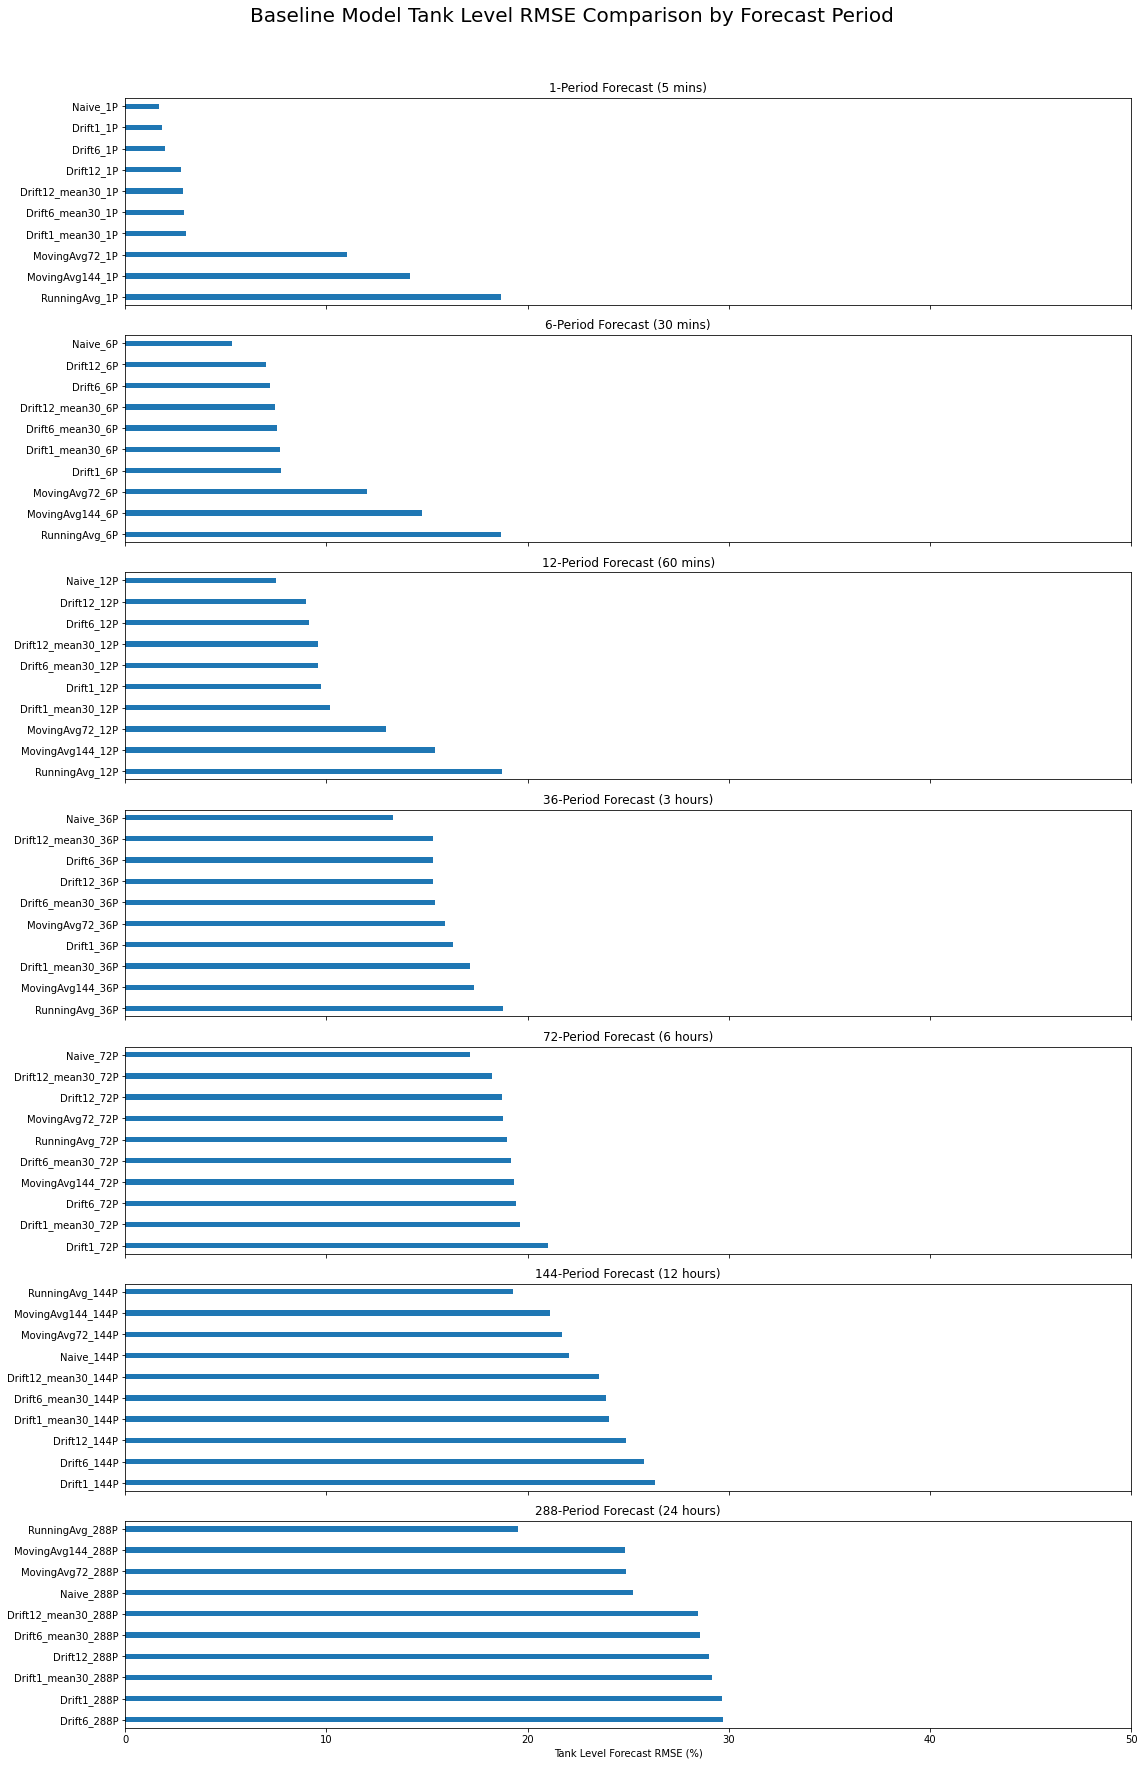

In [20]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
base_model_cols = get_model_result_cols_by_period(period_names, base_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(base_model_cols, device_base_model_rmse_df, 
                                 'Baseline Model Tank Level RMSE Comparison by Forecast Period')


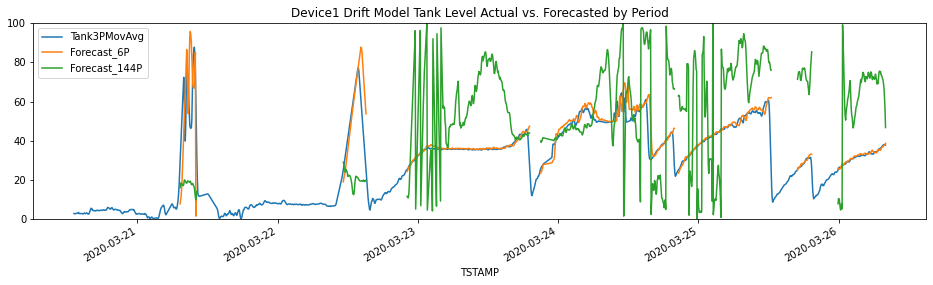

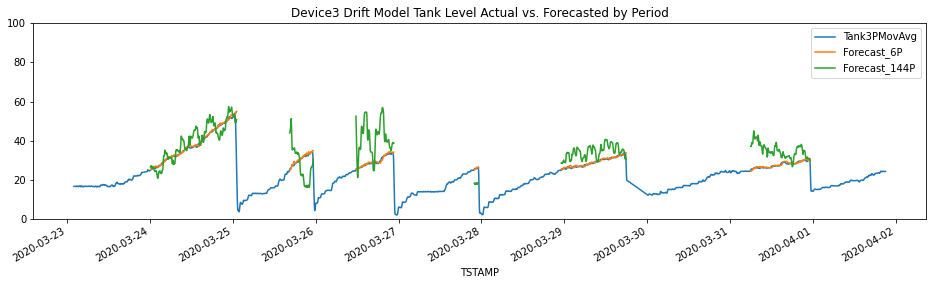

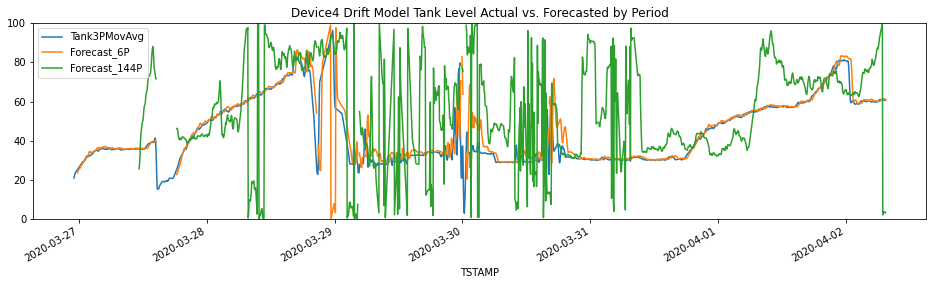

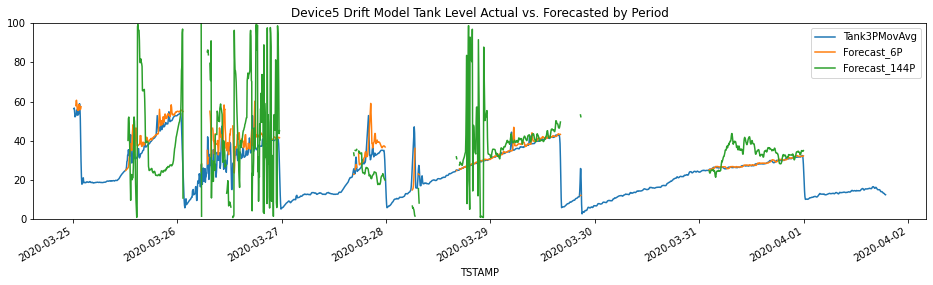

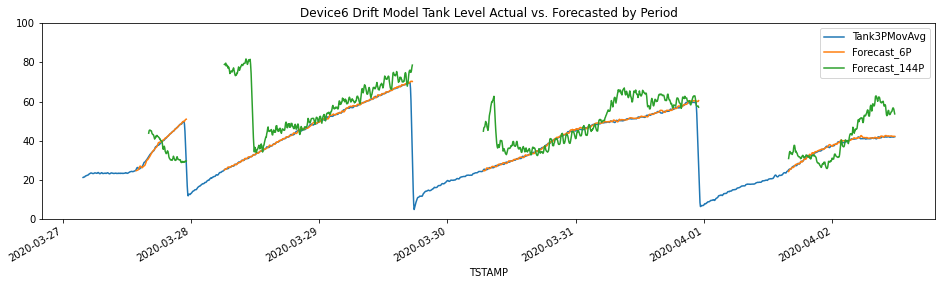

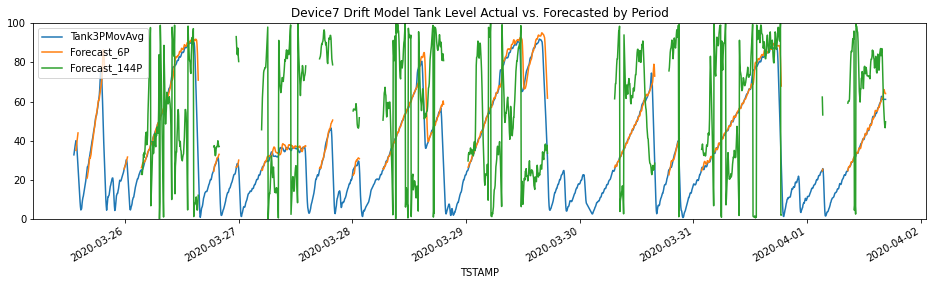

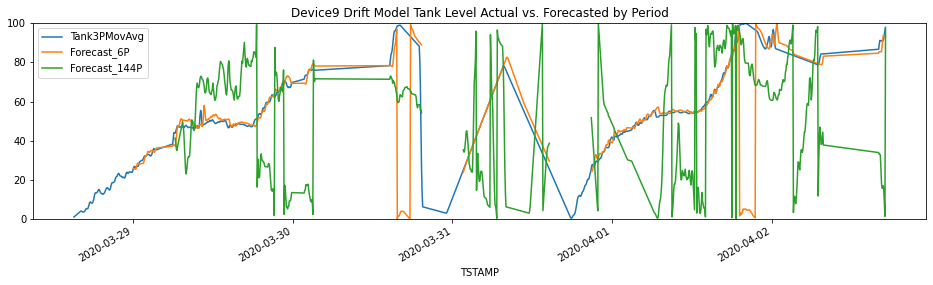

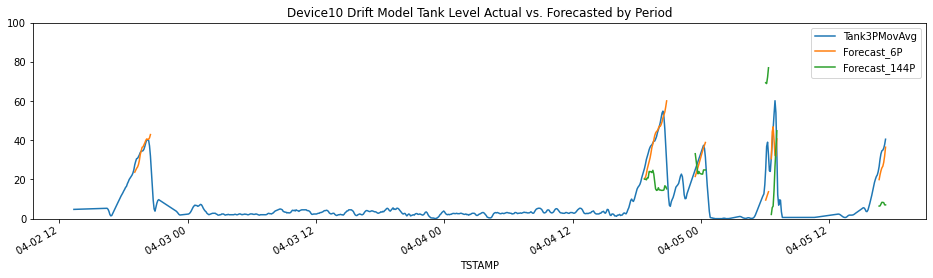

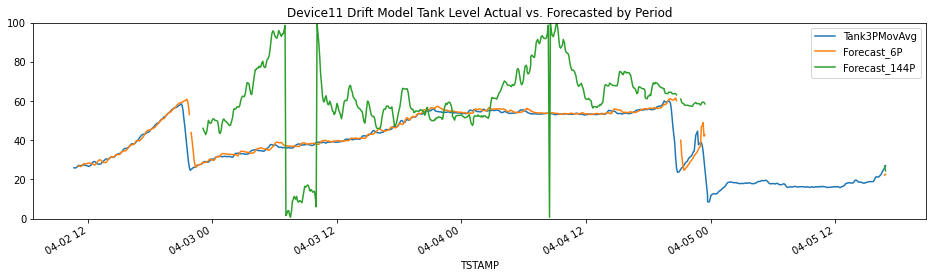

In [21]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
base_forecasts = forecastcsv_to_dfs(file='data/Drift1_mean30_model_forecasts_alldevices.csv', device_ids=device_ids)

# plot_cols = ['Tank3PMovAvg', 'Forecast_6P', 'Forecast_36P']

# plot_forecasts_by_device(base_forecasts, device_ids, plot_cols, 'Drift')

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_144P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(base_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 'Drift', flt_thrsh)





## Exponential Smoothing Model Review and Pipeline

Exponential methods will be used to predict tank level based on level and trend modeling.   

Assumptions of Exponential Smoothing:

https://www.sciencedirect.com/science/article/abs/pii/0169207089900071

https://people.duke.edu/~rnau/411avg.htm

https://yintingchou.com/posts/exponential-smoothing/


### Review full model fit

Load example data for 1-period forecasts on Device 3

In [22]:
# test on Device3
input_col = 'Tank3PMovAvg'
target_col = 'Tank3PMATgt1P'

# filter rows with NaN in the target column
filtnan = ~sap_devices[3][target_col].isna()

# get full dataset
# convert to numpy arrays
inputs = np.array(sap_devices[3][input_col][filtnan])
targets = np.array(sap_devices[3][target_col][filtnan])

inputsidx = sap_devices[3][input_col][filtnan].index


#### Simple Exponential Smoothing (ANN) Review

Verify full model fit to identify automatically-selected exponential smoothing parameters for error (level) only.

The smoothing_level 'alpha' is very close to one; which means that nearly 0 weight is placed on historical values.  The predictions should be very close to the Naive model where the previous value is used as the next predicted value.

In [23]:
model_expETS_ANN = ETSModel(inputs, initialization_method='estimated').fit(maxiter=1000)

model_expETS_ANN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10836
Model:                       ETS(ANN)   Log Likelihood              -15319.511
Date:                Mon, 30 Nov 2020   AIC                          30645.022
Time:                        20:24:39   BIC                          30666.894
Sample:                             0   HQIC                         30652.396
                              - 10836   Scale                            0.990
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.011     90.828      0.000       0.978       1.021
initial_level      92.9000      0.995     93.382      0.000      90.950      94.850
===================================================================================
Ljung-Box (Q):                    13632.44   Jarque-Bera (JB):           1995143.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -6.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [24]:
rmse_results(inputs, model_expETS_ANN.fittedvalues, printout=True)

Mean squared error on test data: 0.9897
Root mean squared error on test data: 0.9948
R-Squared score on test data: 0.9971


(0.9896978187213739, 0.9948355737112409, 0.9970631142519312)

<AxesSubplot:title={'center':'Tank Level Trend actual versus fitted'}, xlabel='TSTAMP'>

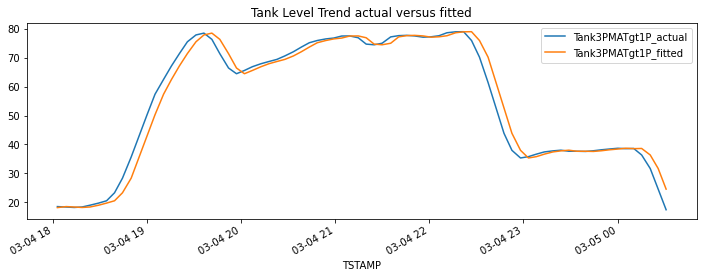

In [25]:
Actual = pd.DataFrame(inputs, index=inputsidx, columns=[target_col])

Predicted = pd.DataFrame(model_expETS_ANN.fittedvalues, index=Actual.index, columns=[target_col])


# plot actual vs. fitted
( Actual.join(Predicted, lsuffix='_actual', rsuffix='_fitted')
    .loc['2020-03-04 18:00':'2020-03-05 00:30']
    .plot(title = "Tank Level Trend actual versus fitted", figsize = (12,4)) 
)

#### Exponential Smoothing with Damped Trend (AAdN) Review

Verify full model fit to identify automatically-selected exponential smoothing parameters for error (level) and trend.  A damping trend parameter auto-fit to prevent the a constant trend indefinitely into the future.

Both the smoothing_level 'alpha' and trend 'beta' are very close to one; which means that nearly 0 weight is placed on historical values.  The trend damping parameter is about 0.9, which means that the constant trend levels out to zero fairly quickly.  

In [26]:
# fit full model
model_expETS_AAdN = ETSModel(inputs, initialization_method='estimated', trend="add", damped_trend=True).fit(maxiter=1000)

model_expETS_AAdN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10836
Model:                      ETS(AAdN)   Log Likelihood               -6664.702
Date:                Mon, 30 Nov 2020   AIC                          13341.403
Time:                        20:24:39   BIC                          13385.147
Sample:                             0   HQIC                         13356.151
                              - 10836   Scale                            0.200
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.015     64.542      0.000       0.970       1.030
smoothing_trend     0.9998      0.024     41.554      0.000       0.953       1.047
damping_trend       0.8931      0.004    202.078      0.000       0.884       0.902
initial_level      92.9000      0.501    185.365      0.000      91.918      93.882
initial_trend       0.0003      0.752      0.000      1.000      -1.474       1.475
===================================================================================
Ljung-Box (Q):                     3284.44   Jarque-Bera (JB):           1049890.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -2.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [27]:
rmse_results(inputs, model_expETS_AAdN.fittedvalues, printout=True)

Mean squared error on test data: 0.2003
Root mean squared error on test data: 0.4476
R-Squared score on test data: 0.9994


(0.20033317927084127, 0.4475859462392014, 0.9994055198991688)

<AxesSubplot:title={'center':'Tank Level Trend actual versus fitted'}, xlabel='TSTAMP'>

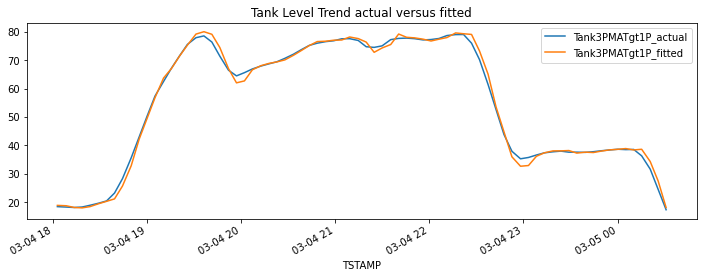

In [28]:
Actual = pd.DataFrame(inputs, index=inputsidx, columns=[target_col])

Predicted = pd.DataFrame(model_expETS_AAdN.fittedvalues, index=Actual.index, columns=[target_col])

# plot actual vs. fitted
( Actual.join(Predicted, lsuffix='_actual', rsuffix='_fitted')
    .loc['2020-03-04 18:00':'2020-03-05 00:30']
    .plot(title = "Tank Level Trend actual versus fitted", figsize = (12,4)) 
)

### Exponential Smoothing Model Pipeline

Test various exponential smoothing models using error and trend components.  Level alpha and trend beta parameters are selected automatically on running history.  Model types are indicated as follows:

ETS, where E = error (level), T = trend, S = seasonal

Each component is indicated by N, A, or M.

- N = None
- A = Additive
- M = Multiplicative

For example, an ANN model has an Additive error component for level forecasting, but no trend or seasonal components.

Additionally, the Trend component can be suffixed with a 'd' to indicate that it is damped so the trend goes to zero after a number of periods.  For example, a AAdN model has an Additive error component and an Additive trend component that is dampened.

Note the 1-period forecast ANN model nearly matches the Naive baseline model score.  This indicates the exponential alpha parameter is optimized close to 1 place nearly all weight on the last value as the predictor of the next period.

For all models, the smoothing parameters can be auto-fit based on statistical likelihood or manually specified.

**Note:**  For this study, Seasonal parameters are not used due to the short-term nature of the process.

In [29]:
# function to train exp model and return period-ahead forecasts
def model_exp_forecast(hist_data, window_size, fcstP, error="add", trend=None, damped_trend=False, 
                       seasonal=None, seasonal_periods=0, smoothing_params={}):
    # window_size = 0:  Full History
    # window_size > 1:  last X obs
    #ETS model (error, trend, seasonality)
    model = ETSModel(hist_data[-window_size:], initialization_method='estimated', 
                     error=error, trend=trend, damped_trend=damped_trend,
                    seasonal=seasonal, seasonal_periods=seasonal_periods)
    # an empty dict of smoothing_params will auto-fit based on max likelihood
    modelfit = model.fit_constrained(constraints=smoothing_params, maxiter=1000)
    # get period-ahead predictions
    predicts = []
    for pp in range(len(fcstP)):
        predict = modelfit.predict(len(hist_data[-window_size:])+fcstP[pp], len(hist_data[-window_size:])+fcstP[pp])        
        # get modulus of tank levels greater than 100% for positive trends
        if predict > 100: predict = predict % 100.0
        if predict < 0: predict = 0
        predicts.append(predict)
        
    # return predictions
    return predicts

# function to process exponential model step-forward validation for univariate data
def model_exp_step_forward_validation(df, input_cols, target_cols, pct_test=0.2, window_size=0,
                                     fcstP=[1], error="add", trend=None, damped_trend=False,
                                     seasonal=None, seasonal_periods=0, 
                                     smoothing_params={}, flt_thrsh=0, printout=False):

    inputs = np.array(df[input_cols[0]])
    #split train and test data
    n_test = int(len(inputs)*pct_test)
    train = inputs[:-n_test]
    test = inputs[-n_test:]

    #initialize dataframe to store actuals and predictions
    #  the initial df is populated with the device id, predicted input, and exog input
    #  add offset of the first forcast period to align with periodtargets
    forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+fcstP[0]:]

    # timestamp index of target values
    testtargetidx = df[input_cols[0]][-n_test:].index.to_series()
    # reset index from datetime to int
    testtargetidx = testtargetidx.reset_index(drop=True)

    # populate period forecast actuals
    periodtargets = []
    periodtargetsidx = []    
    for cc in range(len(target_cols)):
        # build list of period targets
        # filter rows with NaN in the target column
        filtnan = ~df[target_cols[cc]][-n_test:].isna()
        # convert to numpy arrays
        targets = np.array(df[target_cols[cc]][-n_test:][filtnan])
        periodtargets.append([targets])

        # build list of period target timestamps
        # filter rows with NaN in the target column
        filtnanidx = ~df[target_cols[cc]][-n_test:].isna().reset_index(drop=True)
        # align timestamp index of target value by shifting target timestamps backward
        idx = testtargetidx.shift(-fcstP[cc])
        assert len(filtnanidx) == len(idx)
        idx = idx[filtnanidx]
        periodtargetsidx.append([idx]) 

    
    #initialize predictions list
    predictions = []

    # seed history with training dataset
    history = np.array([xx for xx in train])
    # step into each time-step in the test set
    for ii in range(len(test)):
        # add actual observation to history for the loop
        history = np.append(history, test[ii])
        # fit model and make forecast from history
        predicts = model_exp_forecast(history, window_size=window_size, fcstP=fcstP, error=error,
                                    trend=trend, damped_trend=damped_trend, seasonal=seasonal,
                                    seasonal_periods=seasonal_periods, smoothing_params=smoothing_params)
        # store forecasts in lists of predictions
        for cc in range(len(target_cols)):
            if len(predictions) < len(target_cols):
                # initialize outer list with first period prediction
                predictions.append([predicts[cc]])
            else:
                # append to inner list with period predictions
                predictions[cc].append(predicts[cc])
        
    #debug
    # print(len(predictions))
    # print(len(test))
    # print(len(history))
    # loop through each period predictions to measure results of actual vs. forecast
    results = [] # list of results metrics
    dfs = [forecasts_df] # list of dataframes of forecasts for plotting
    for cc in range(len(target_cols)):
        # create array of target actuals for each period
        testactuals = np.asarray(periodtargets[cc][0])
        # create array of forecasts as the same length as the test actuals
        forecasts = np.asarray(predictions[cc][:len(testactuals)])
        assert len(testactuals) == len(forecasts)
        
        # filter forecasts and actuals indexes with NaN in the forecasts (if any)
        filtnan = ~np.isnan(forecasts)
        testactuals = testactuals[filtnan]
        forecasts = forecasts[filtnan]  
        
        # build df of forecasts aligned index of actual time
        df = pd.DataFrame(data=forecasts, index=periodtargetsidx[cc][0][-len(forecasts):], columns=[f'Forecast_{fcstP[cc]}P'])
        dfs.append(df)        
        
        # get results per priod
        mse, rmse, r2score = rmse_results(testactuals, forecasts, flt_thrsh=flt_thrsh, printout=printout)
        # append results to results list
        results.append([mse, rmse, r2score])

    forecasts_df = pd.concat(dfs, axis=1)          
        
    return results, forecasts_df


#### ANN model walk-forward validation test

In [30]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# auto-fit params
smoothing_params = {}
# manually specify params
# smoothing_params = {'smoothing_level':0.8}
               
# full running history; window_size = 0
ANN_results, forecasts_df = model_exp_step_forward_validation(sap_devices[3], input_cols, target_cols, 
                                                              pct_test=0.1, window_size=0, 
                                                              fcstP=periods, error="add", 
                                                              smoothing_params=smoothing_params, flt_thrsh=flt_thrsh,
                                                              printout=True)

ANN_results



Mean squared error on test data: 0.0943
Root mean squared error on test data: 0.3071
R-Squared score on test data: 0.9778
Mean squared error on test data: 0.3616
Root mean squared error on test data: 0.6013
R-Squared score on test data: 0.9143
Mean squared error on test data: 0.5765
Root mean squared error on test data: 0.7592
R-Squared score on test data: 0.8615
Mean squared error on test data: 1.8332
Root mean squared error on test data: 1.3539
R-Squared score on test data: 0.5538
Mean squared error on test data: 5.2449
Root mean squared error on test data: 2.2902
R-Squared score on test data: -0.2664
Mean squared error on test data: 16.0192
Root mean squared error on test data: 4.0024
R-Squared score on test data: -2.2524
Mean squared error on test data: 83.6998
Root mean squared error on test data: 9.1488
R-Squared score on test data: -39.5637
Wall time: 45.1 s


[[0.09430352810488997, 0.30708879514708765, 0.9778451204894634],
 [0.3615986060694987, 0.6013306960978283, 0.9142927772523143],
 [0.576458291726497, 0.7592485045928619, 0.8614935494765061],
 [1.8331794972170665, 1.3539495918301636, 0.5538399236590628],
 [5.244929416824299, 2.2901810882164533, -0.2664170857770025],
 [16.019219873309357, 4.002401763105418, -2.252367312146874],
 [83.69984153788079, 9.148761748886063, -39.56368877641421]]

#### AAdN model walk-forward validation test

In [31]:
%%time

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# auto-fit params
smoothing_params = {}
# manually specify params
# smoothing_params = {'smoothing_level':0.95, 'smoothing_trend':0.03, 'damping_trend':0.98}

# full running history; window_size = 0
AAdN_results, forecasts_df = model_exp_step_forward_validation(sap_devices[3], input_cols, target_cols, 
                                                              pct_test=0.1, window_size=144, 
                                                              fcstP=periods, error="add", trend="add", 
                                                              damped_trend=True, 
                                                              smoothing_params=smoothing_params, flt_thrsh=flt_thrsh,
                                                              printout=True)

AAdN_results



Mean squared error on test data: 0.0539
Root mean squared error on test data: 0.2321
R-Squared score on test data: 0.9873
Mean squared error on test data: 0.4381
Root mean squared error on test data: 0.6619
R-Squared score on test data: 0.8962
Mean squared error on test data: 0.7574
Root mean squared error on test data: 0.8703
R-Squared score on test data: 0.8180
Mean squared error on test data: 1.7992
Root mean squared error on test data: 1.3413
R-Squared score on test data: 0.5621
Mean squared error on test data: 5.1090
Root mean squared error on test data: 2.2603
R-Squared score on test data: -0.2336
Mean squared error on test data: 15.7567
Root mean squared error on test data: 3.9695
R-Squared score on test data: -2.1991
Mean squared error on test data: 80.2399
Root mean squared error on test data: 8.9577
R-Squared score on test data: -37.8869
Wall time: 25.1 s


[[0.05385093910526333, 0.23205805115372174, 0.9873487122763915],
 [0.43808562035549936, 0.6618803671023181, 0.8961635879781286],
 [0.7574259671006449, 0.8703022274478245, 0.8180121897054623],
 [1.7991944695006752, 1.3413405494134125, 0.5621112154684096],
 [5.108978687764054, 2.260304998836231, -0.23359103371356427],
 [15.756694810084248, 3.969470343771855, -2.199067092722628],
 [80.23992338870441, 8.95767399433047, -37.88689894722989]]

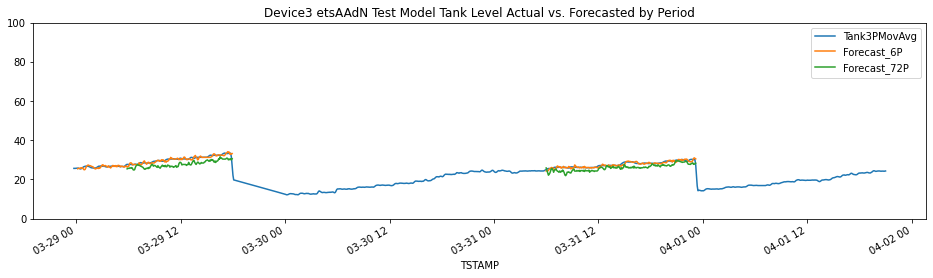

In [32]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values
df_dict = {3:forecasts_df}
plot_cols = ['Tank3PMovAvg', 'Forecast_6P', 'Forecast_288P']
ids = [3]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_72P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(df_dict, ids, threshhold_col, actual_cols, forecast_cols, 'etsAAdN Test', flt_thrsh)



#### Exponential Model Pipeline

In [33]:
%%time

# loop through ETS models for each device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]

# dict of model names and parameters (window size, error, trend, damped, smoothing_params)
exp_models = {'etsfullAautoNN':[0, "add", None, False, {}], 
          'etsfullAautoAautoN':[0, "add", "add", False, {}],     
          'etsfullAautoAautoDautoN':[0, "add", "add", True, {}],                   
          'ets144AautoNN':[144, "add", None, False, {}], 
          'ets144AautoAautoN':[144, "add", "add", False, {}],          
          'ets144AautoAautoDautoN':[144, "add", "add", True, {}],
          'ets72AautoNN':[72, "add", None, False, {}], 
          'ets72AautoAautoN':[72, "add", "add", False, {}],          
          'ets72AautoAautoDautoN':[72, "add", "add", True, {}]                    
             }

# initialize dict of model results
device_exp_model_rmse = {}

# initialize dict of forecast results
device_exp_model_forecasts = {}

# initialize dict of model processing times
device_exp_model_process_time = {}

for ii in device_ids:
    print(f'Processing device{ii}...')
    df = sap_devices[ii]

    for mm in exp_models:
        print(f'testing model {mm}')
        # store starting time 
        begin = time.time() 
        
        params = exp_models[mm]
        results, forecasts_df = model_exp_step_forward_validation(df, input_cols, target_cols, pct_test=0.25, 
                                                                  window_size=params[0], fcstP=periods, flt_thrsh=flt_thrsh, 
                                                                  error=params[1], trend=params[2], 
                                                                  damped_trend=params[3], 
                                                                  smoothing_params=params[4])
        
        # store ending time
        end = time.time()
        # capture model forecast results
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_exp_model_forecasts:
            device_exp_model_forecasts[mm][ii] = forecasts_df
        else:
            device_exp_model_forecasts[mm] = {}
            device_exp_model_forecasts[mm][ii] = forecasts_df
            
        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_exp_model_process_time:
            device_exp_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_exp_model_process_time[devicekey] = {}
            device_exp_model_process_time[devicekey][mm] = (end - begin)            
        
        #populate rmse score for each period
        for pp in range(len(periods)):
            device_exp_model_rmse = set_device_model_rmse_dict(device_exp_model_rmse, f'device{ii}', 
                                                           mm+'_'+period_names[pp], results[pp][1])            


Processing device1...
testing model etsfullAautoNN
testing model etsfullAautoAautoN
testing model etsfullAautoAautoDautoN
testing model ets144AautoNN
testing model ets144AautoAautoN
testing model ets144AautoAautoDautoN
testing model ets72AautoNN
testing model ets72AautoAautoN
testing model ets72AautoAautoDautoN
Processing device3...
testing model etsfullAautoNN
testing model etsfullAautoAautoN
testing model etsfullAautoAautoDautoN
testing model ets144AautoNN
testing model ets144AautoAautoN
testing model ets144AautoAautoDautoN
testing model ets72AautoNN
testing model ets72AautoAautoN
testing model ets72AautoAautoDautoN
Processing device4...
testing model etsfullAautoNN
testing model etsfullAautoAautoN
testing model etsfullAautoAautoDautoN
testing model ets144AautoNN
testing model ets144AautoAautoN
testing model ets144AautoAautoDautoN
testing model ets72AautoNN
testing model ets72AautoAautoN
testing model ets72AautoAautoDautoN
Processing device5...
testing model etsfullAautoNN
testing mo

In [34]:
# convert model results dict to a dataframe
device_exp_model_rmse_df = pd.DataFrame.from_dict(device_exp_model_rmse, orient='index')

# convert model processing times dict to a dataframe
device_exp_model_process_time_df = pd.DataFrame.from_dict(device_exp_model_process_time, orient='index')

# save results to file
device_exp_model_rmse_df.to_csv('data/ets_model_results_alldevices.csv', index=True, header=True)
device_exp_model_process_time_df.to_csv('data/ets_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_exp_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('Exponential forecast results:')
device_exp_model_rmse_df  
            

Exponential forecast results:


,etsfullAautoNN_1P,etsfullAautoNN_6P,etsfullAautoNN_12P,etsfullAautoNN_36P,etsfullAautoNN_72P,etsfullAautoNN_144P,etsfullAautoNN_288P,etsfullAautoAautoN_1P,etsfullAautoAautoN_6P,etsfullAautoAautoN_12P,...,ets72AautoAautoN_72P,ets72AautoAautoN_144P,ets72AautoAautoN_288P,ets72AautoAautoDautoN_1P,ets72AautoAautoDautoN_6P,ets72AautoAautoDautoN_12P,ets72AautoAautoDautoN_36P,ets72AautoAautoDautoN_72P,ets72AautoAautoDautoN_144P,ets72AautoAautoDautoN_288P
device1,2.068970,7.169340,9.394951,16.990293,20.491084,22.544351,20.351735,3.765463,10.188114,13.636036,...,26.537656,32.619661,32.162466,2.084235,8.534673,10.765242,16.919894,21.013701,23.697181,21.757404
device3,0.555824,1.514195,1.667471,3.169986,5.815363,10.791119,15.708089,0.455751,1.871943,2.556650,...,9.960779,18.979395,26.189851,0.433129,1.568596,1.652598,2.959371,5.536759,10.517741,15.682747
device4,1.695539,5.665541,6.912930,11.041953,13.046824,18.595890,25.061297,2.986625,9.937512,12.582964,...,20.486855,25.380224,31.578066,1.967751,7.724457,9.676812,13.280712,14.493666,19.086114,25.606641
device5,1.851889,4.578099,5.304970,6.937299,10.307439,15.057517,13.960802,2.433257,7.705999,10.761179,...,13.931210,22.926343,29.314217,2.147520,5.440582,7.530478,8.773781,11.037972,15.580015,15.574167
device6,0.734291,2.309335,2.566377,4.544545,8.109332,14.534678,25.668451,0.649180,2.512980,2.980297,...,7.453216,18.087367,30.789578,0.615827,2.303634,2.436878,4.035517,7.346308,13.999526,25.291946
device7,1.616814,7.388023,10.324889,18.968764,28.989582,39.560736,30.582147,1.669448,6.955895,13.623453,...,33.258789,41.148831,37.548409,1.460313,6.476311,10.478974,18.814347,27.859552,39.315049,32.702333
device9,1.340790,4.196106,6.429937,15.089557,24.330901,33.074630,43.749718,9.361634,17.458769,20.245953,...,32.276588,40.618761,49.894464,4.856243,14.792420,15.664281,18.280879,25.956071,34.985702,45.691808
device10,4.219552,11.620161,19.523914,33.971000,32.113340,33.665767,35.683266,4.114061,10.185373,13.416830,...,33.518378,33.647493,34.241290,4.085811,13.802279,13.649201,33.968087,33.185771,33.062187,35.671080
device11,0.906996,3.476611,5.540118,9.133714,10.940798,10.779463,16.153053,1.217505,4.908291,7.139146,...,22.729588,26.011695,30.970337,1.072952,4.318859,6.389188,9.956356,11.862679,11.923868,17.232984


#### Exponential Smoothing Model Results

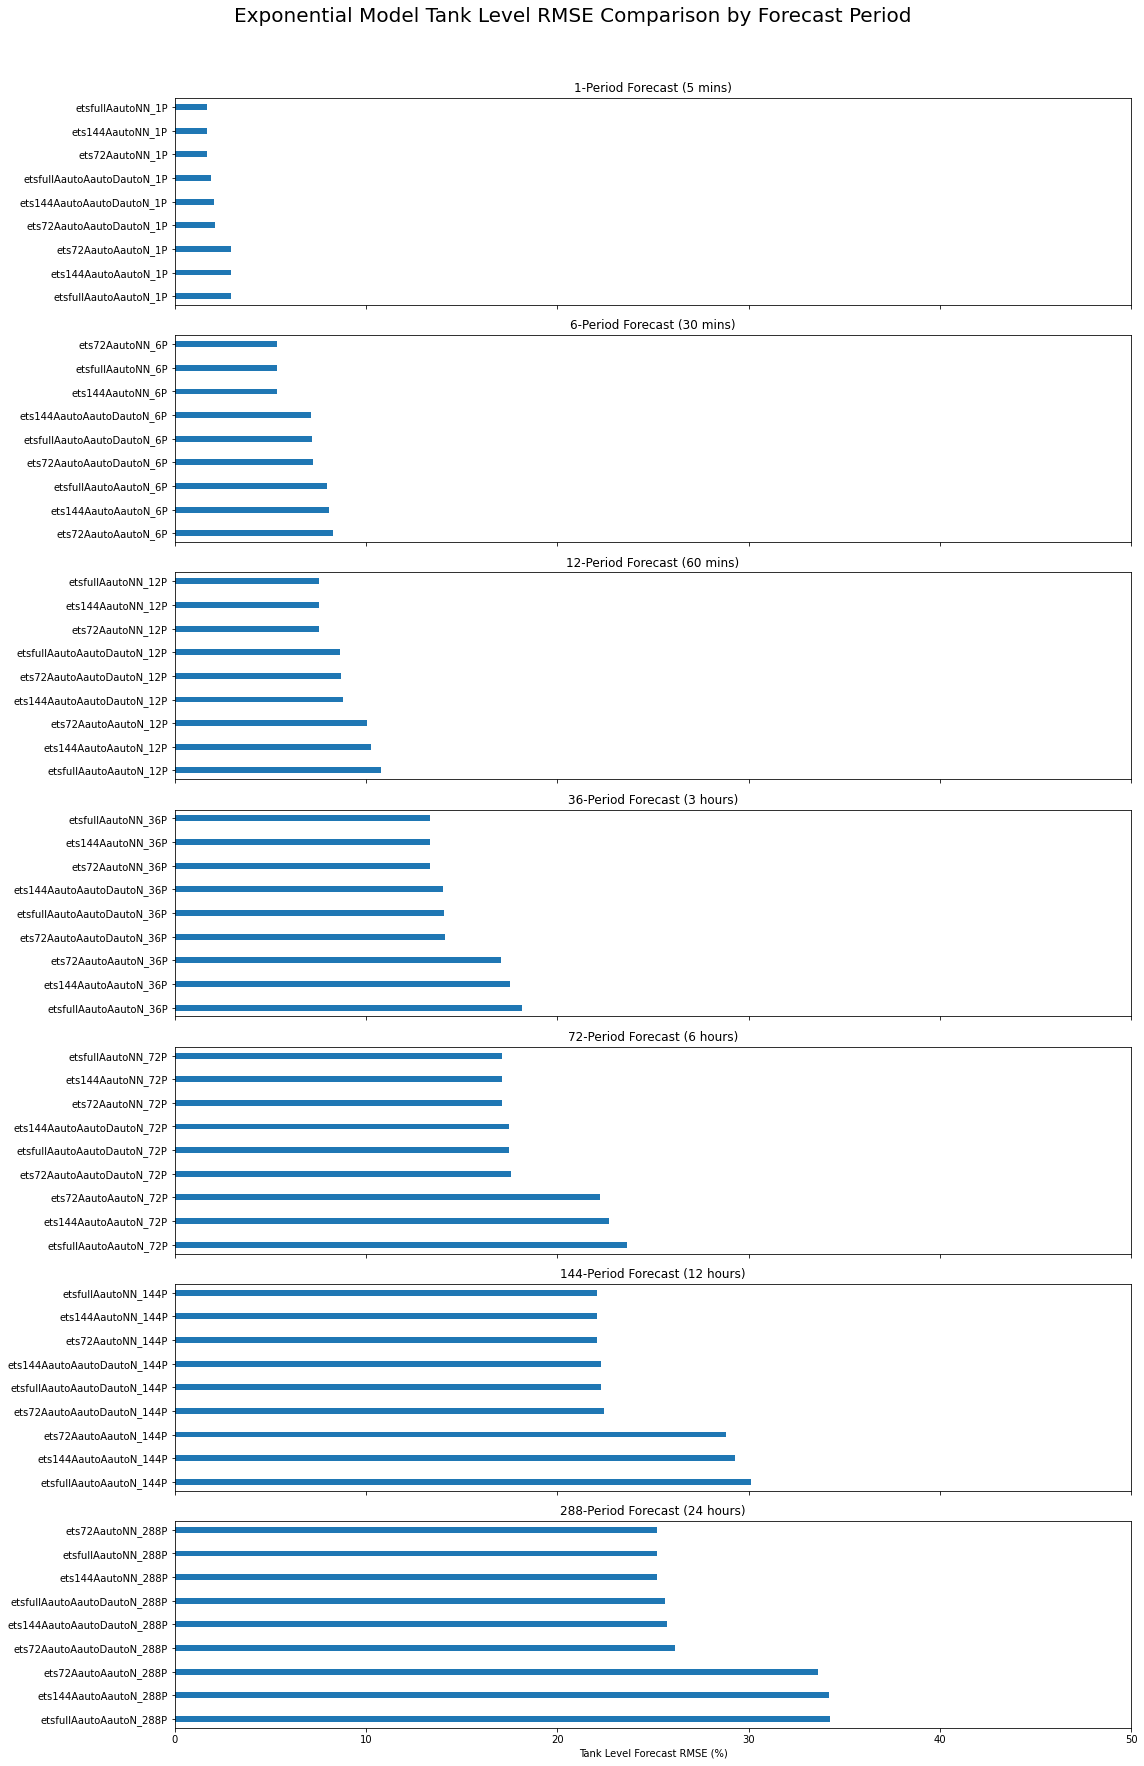

In [35]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
exp_model_cols = get_model_result_cols_by_period(period_names, exp_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(exp_model_cols, device_exp_model_rmse_df, 
                                 'Exponential Model Tank Level RMSE Comparison by Forecast Period')


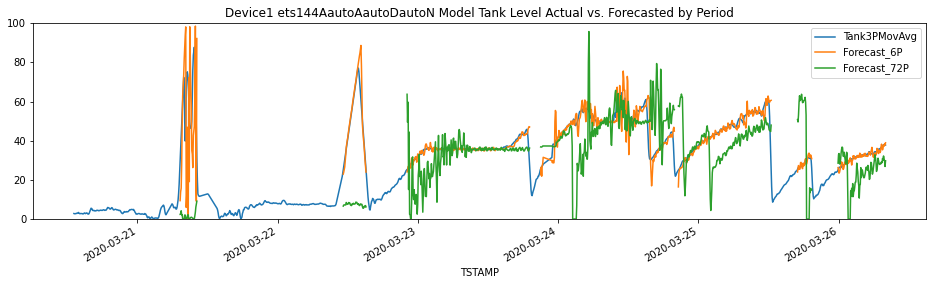

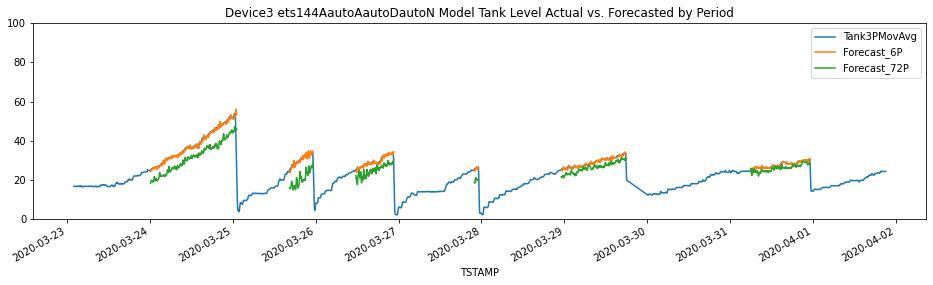

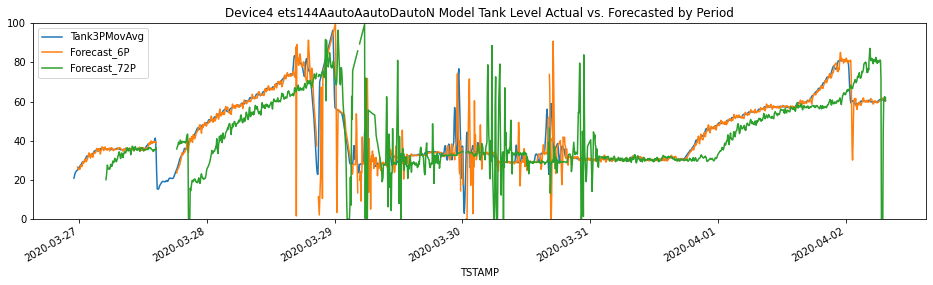

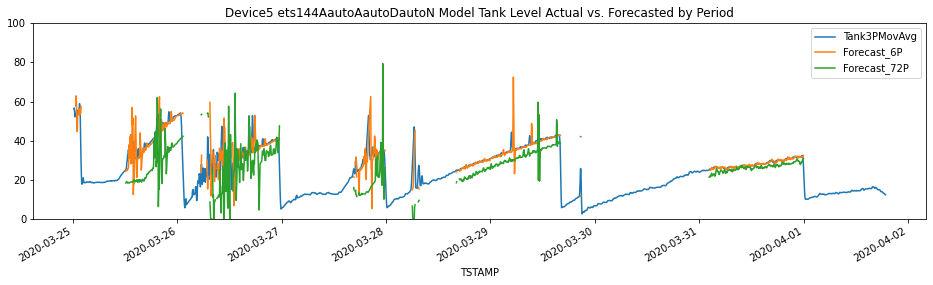

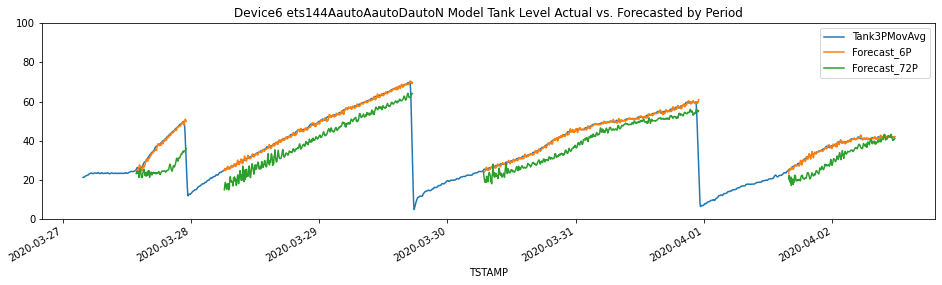

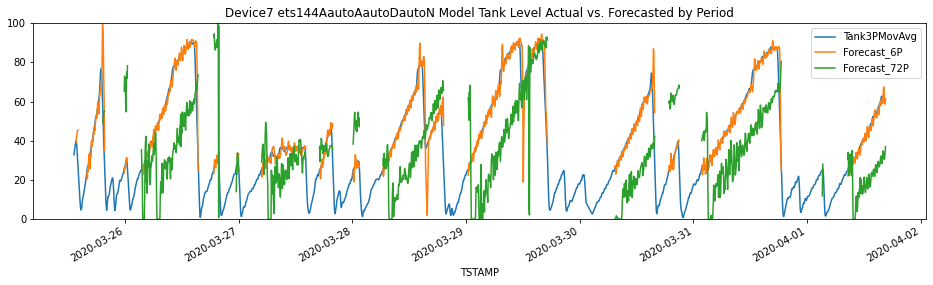

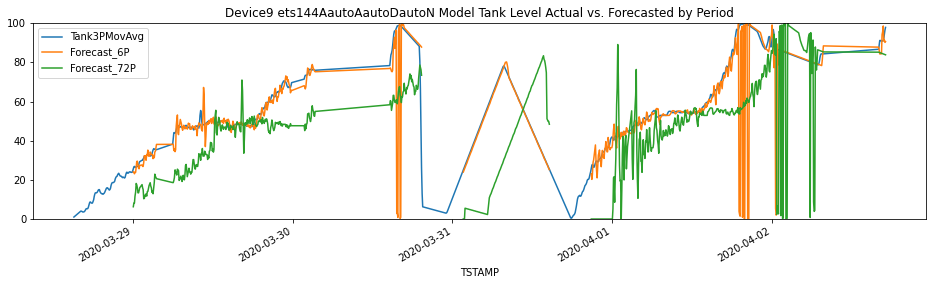

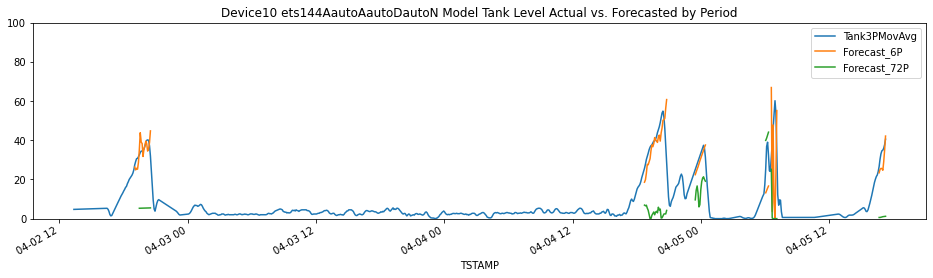

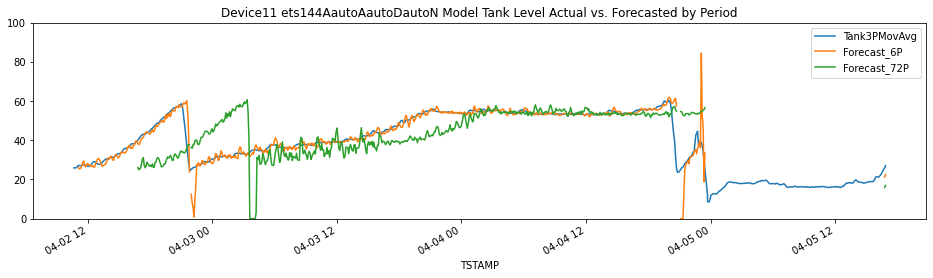

In [36]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
exp_forecasts = forecastcsv_to_dfs(file='data/ets144AautoAautoDautoN_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_72P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(exp_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 
                         'ets144AautoAautoDautoN', flt_thrsh)



## ARIMA Model Review and Pipeline

Test on auto regressive integrated moving average (ARIMA) statistical model.

Load example data for 1-period forecasts on Device 3.

In [37]:
# test on Device3
input_col = 'Tank3PMovAvg'
target_col = 'Tank3PMATgt1P'

# filter rows with NaN in the target column
filtnan = ~sap_devices[3][target_col].isna()

# get full dataset
# convert to numpy arrays
inputs = np.array(sap_devices[3][input_col][filtnan])
targets = np.array(sap_devices[3][target_col][filtnan])

inputsidx = sap_devices[3][input_col][filtnan].index

### Review Univariate full model fit

About comparison of ARIMA with simpler methods:

https://stats.stackexchange.com/questions/124955/is-it-unusual-for-the-mean-to-outperform-arima

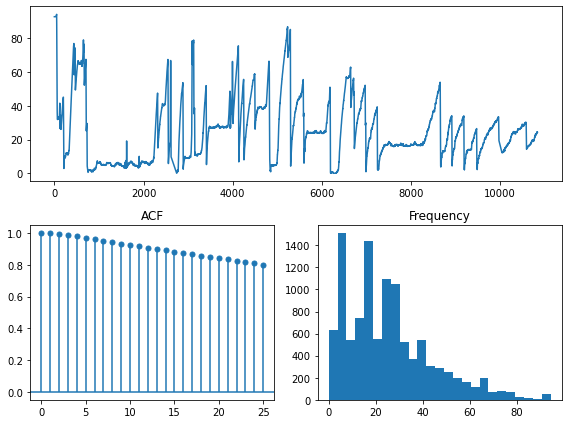

In [38]:
pm.tsdisplay(inputs, lag_max=25)



#### Test for stationarity

Run  Augmented Dickey-Fuller test that the time series is stationary.

**Null Hypothesis**:  Series has a unit root and is non-stationary.

We reject the Null Hypothesis that the series is non-stationary at a 1% significance level.  Therefore, we will not further transform the series to make it stationary.

In [39]:
from statsmodels.tsa.stattools import adfuller

# check if stationary
result = adfuller(inputs)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -7.0214
p-value: 6.529426353716269e-10
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Run the ndiffs function from the pmdarima library to automatically test and select the recommended number of diffs for the ARIMA model.  This function confirms that the data is already stationary and no additional diffs are recommended.

In [40]:
from pmdarima.arima.utils import ndiffs

print(ndiffs(inputs, test='adf'))

0


#### Auto fit with pmdarima

In [41]:
model = pm.auto_arima(inputs, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series 1 == no seasonality
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20411.205, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=105301.662, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10526.732, Time=0.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13298.650, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8713.492, Time=2.87 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8253.107, Time=2.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=7266.593, Time=5.30 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=inf, Time=7.37 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=8093.843, Time=5.68 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8662.218, Time=5

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10836
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -2700.882
Date:                Mon, 30 Nov 2020   AIC                           5421.764
Time:                        22:19:07   BIC                           5494.670
Sample:                             0   HQIC                          5446.344
                              - 10836                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0072      0.002      3.518      0.000       0.003       0.011
ar.L1          2.7285      0.008    344.212      0.000       2.713       2.744
ar.L2         -2.4255      0.018   -137.502      0.000      -2.460      -2.391
ar.L3          0.7516      0.018     42.511      0.000       0.717       0.786
ar.L4         -0.1507      0.012    -12.483      0.000      -0.174      -0.127
ar.L5          0.0958      0.004     22.281      0.000       0.087       0.104
ma.L1          0.0003      0.007      0.042      0.967      -0.014       0.014
ma.L2         -0.0050      0.007     -0.738      0.461      -0.018       0.008
ma.L3         -0.9278      0.007   -132.664      0.000      -0.942      -0.914
sigma2         0.0957      0.000    286.793      0.000       0.095       0.096
===================================================================================
Ljung-Box (L1) (Q):                   2.33   Jarque-Bera (JB):           3336933.58
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

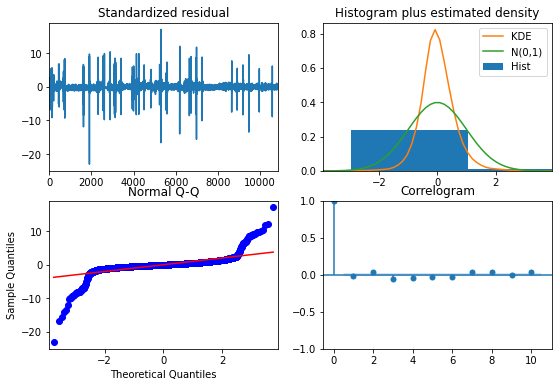

In [43]:
model.plot_diagnostics(figsize=(9,6))

plt.show()

In [44]:
model.order

(5, 0, 3)

#### Plot ACF and PACF of residuals

In [45]:
resids = model.resid()

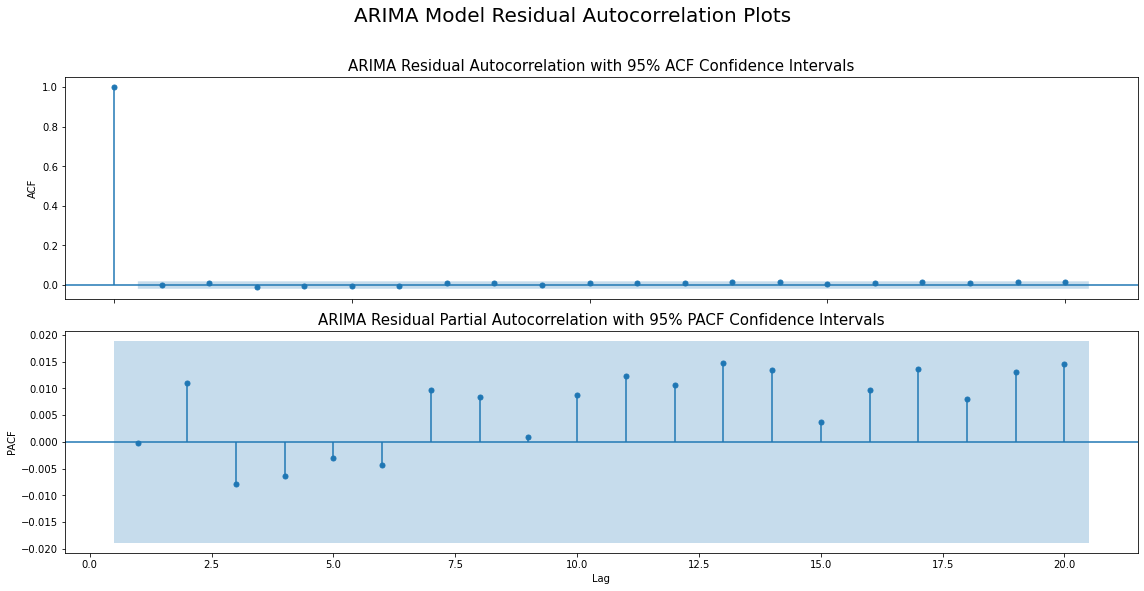

In [46]:
# plot ACF and PACF of residuals

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(16,8))
fig.suptitle(f'ARIMA Model Residual Autocorrelation Plots', size = 20, y=1.02)

# create plot for each device
plot_acf(resids, ax=axs[0], lags=20)
plot_pacf(resids, ax=axs[1], lags=20, zero=False)

# title each subplot
axs[0].set_title(f'ARIMA Residual Autocorrelation with 95% ACF Confidence Intervals', size=15, y=1)
axs[1].set_title(f'ARIMA Residual Partial Autocorrelation with 95% PACF Confidence Intervals', size=15, y=1)
# label each y-axis
axs[0].set_ylabel('ACF')
axs[1].set_ylabel('PACF')
# label each x-axis
axs[0].set_xlabel('')
axs[1].set_xlabel('Lag')    
# remove x-axis tick labels except for bottom row
axs[0].set_xticklabels([])
    
plt.tight_layout()    

The auto-fit ARIMA model on Device 3 appears to describe the auto-correlation well, as no significant ACF or PACF lags exist on the full-fit diagnostic plots.

#### Ljung-Box test for residual autocorrelation

Test for residual autocorrelation with Ljung-Box test.

**Null Hypothesis:**  Autocorrelation is zero (i.e. no serial correlation exists between the residuals)

If a lag p-value < 0.05, we will have evidence to reject the Null Hypothesis at a 5% significance.

In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(resids, lags=10, return_df=True)


,lb_stat,lb_pvalue
1,0.000303,0.986113
2,1.312924,0.518683
3,1.970456,0.578561
4,2.403340,0.662024
5,2.513770,0.774420
6,2.718665,0.843238
7,3.758867,0.807095
8,4.519251,0.807504
9,4.538313,0.872557
10,5.374053,0.864833


We do not reject the Null Hypothesis of no residual autocorrelation.

### Review with Temperature as an exogenous variable full model fit

#### Auto fit with pmdarima

In [48]:
# test on Device3
input_col = 'Tank3PMovAvg'

# get full dataset
# convert to numpy arrays
inputs = np.array(sap_devices[3][input_col])
exogs = sap_devices[3][['TempF']]



In [49]:
modelexog = pm.auto_arima(inputs, exogenous=exogs, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series 1 == no seasonality
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20414.085, Time=3.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=91292.397, Time=1.84 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=76575.783, Time=1.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10525.468, Time=4.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=3.51 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8714.006, Time=9.90 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=5.15 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8251.563, Time=10.91 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=6.92 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=7266.438, Time=14.33 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=10.54 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=6891.170, Time=16.35 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=13.40 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=inf, Time=17

In [50]:
modelexog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10837
Model:               SARIMAX(6, 0, 1)   Log Likelihood               -3429.159
Date:                Mon, 30 Nov 2020   AIC                           6878.318
Time:                        22:23:00   BIC                           6951.225
Sample:                             0   HQIC                          6902.898
                              - 10837                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0434      0.007      5.984      0.000       0.029       0.058
TempF          0.0074      0.003      2.492      0.013       0.002       0.013
ar.L1          2.4176      0.014    169.983      0.000       2.390       2.445
ar.L2         -1.8401      0.035    -53.266      0.000      -1.908      -1.772
ar.L3         -0.1424      0.027     -5.227      0.000      -0.196      -0.089
ar.L4          1.2189      0.008    159.350      0.000       1.204       1.234
ar.L5         -0.9080      0.012    -76.791      0.000      -0.931      -0.885
ar.L6          0.2523      0.005     49.368      0.000       0.242       0.262
ma.L1          0.0794      0.015      5.377      0.000       0.050       0.108
sigma2         0.1102      0.000    325.669      0.000       0.110       0.111
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           1069887.56
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

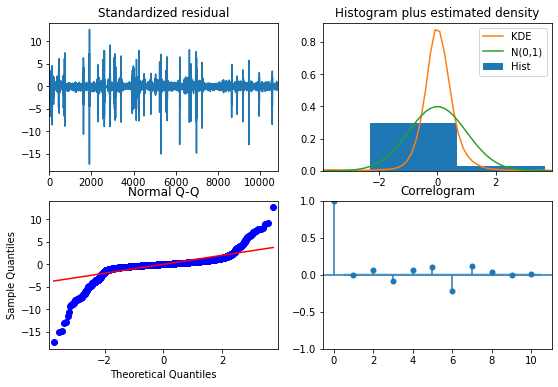

In [51]:
modelexog.plot_diagnostics(figsize=(9,6))

plt.show()

In [52]:
modelexog.order

(6, 0, 1)

#### Plot ACF and PACF of residuals

In [53]:
resids = modelexog.resid()

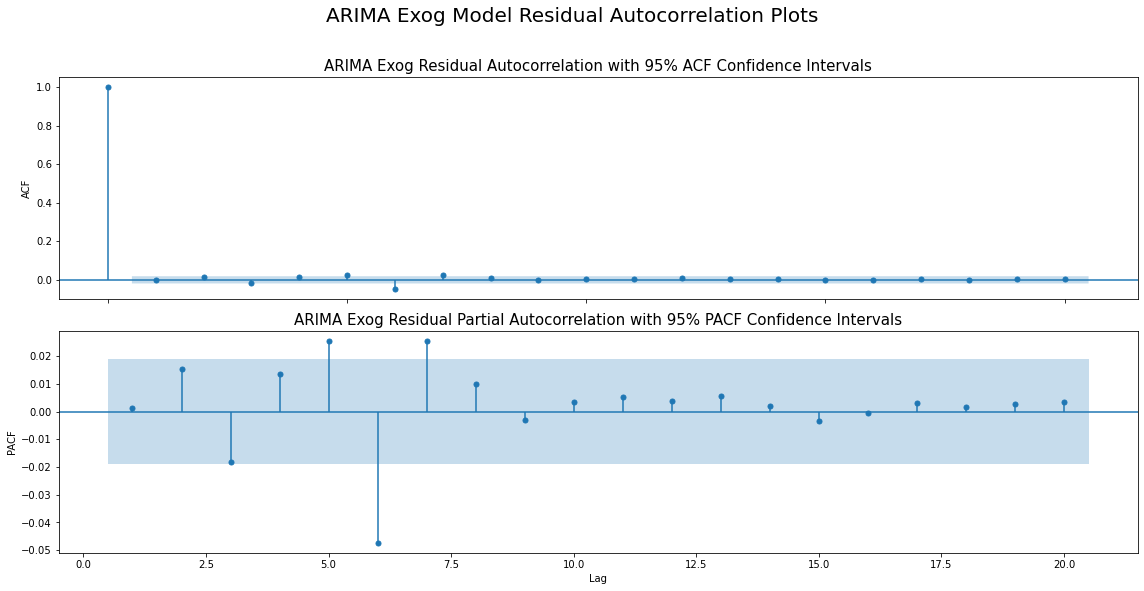

In [54]:
# plot ACF and PACF of residuals

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(16,8))
fig.suptitle(f'ARIMA Exog Model Residual Autocorrelation Plots', size = 20, y=1.02)

# create plot for each device
plot_acf(resids, ax=axs[0], lags=20)
plot_pacf(resids, ax=axs[1], lags=20, zero=False)

# title each subplot
axs[0].set_title(f'ARIMA Exog Residual Autocorrelation with 95% ACF Confidence Intervals', size=15, y=1)
axs[1].set_title(f'ARIMA Exog Residual Partial Autocorrelation with 95% PACF Confidence Intervals', size=15, y=1)
# label each y-axis
axs[0].set_ylabel('ACF')
axs[1].set_ylabel('PACF')
# label each x-axis
axs[0].set_xlabel('')
axs[1].set_xlabel('Lag')    
# remove x-axis tick labels except for bottom row
axs[0].set_xticklabels([])
    
plt.tight_layout() 

#### Ljung-Box test for residual autocorrelation

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(resids, lags=10, return_df=True)


,lb_stat,lb_pvalue
1,0.017428,8.949730e-01
2,2.539129,2.809540e-01
3,6.112458,1.062653e-01
4,8.206908,8.428625e-02
5,14.852524,1.101142e-02
6,38.175452,1.038036e-06
7,45.145062,1.281731e-07
8,45.784880,2.611618e-07
9,45.786446,6.597417e-07
10,45.835606,1.536006e-06


We reject the Null Hypothesis of no autocorrelation at Lag 5, as shown on the ACF plot.

### ARIMA walk-forward testing

In [56]:
# auto fit best arima model
def auto_arima_model(train_data):

    model = pm.auto_arima(train_data, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=6, max_q=6, # maximum p and q
                          m=1,              # frequency of series 1 == no seasonality
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

    # return (p,d,q) params of selected model
    return model, model.order

# return arima exog model forecasts
def model_arima_forecast(model, fcstP):
    # get period-ahead prediction (predict_in_sample is pmdarima method)
    predicts = []
    for pp in range(len(fcstP)):
        predict = model.predict_in_sample(start=model.nobs_+fcstP[pp], end=model.nobs_+fcstP[pp])
        # convert to scalar
        predict = predict.item()
        if predict > 100: predict = 100
        if predict < 0: predict = 0

        predicts.append(predict)

    # return prediction
    return predicts

# function to process arima model step-forward validation
def model_arima_step_forward_validation(df, input_cols, target_cols, pct_test=0.2, window_size=0,
                                     fcstP=[1], flt_thrsh=0, printout=False):
    
    # input values of time series
    inputs = np.array(df[input_cols[0]])

    #split train and test data
    n_test = int(len(inputs)*pct_test)
    train = inputs[:-n_test]
    test = inputs[-n_test:]

    #initialize dataframe to store actuals and predictions
    #  the initial df is populated with the device id, predicted input, and exog input
    #  add offset of the first forcast period to align with periodtargets
    forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+fcstP[0]:]
    
    # timestamp index of target values
    testtargetidx = df[input_cols[0]][-n_test:].index.to_series()
    # reset index from datetime to int
    testtargetidx = testtargetidx.reset_index(drop=True)

    # period target values
    periodtargets = []
    periodtargetsidx = []
    for cc in range(len(target_cols)):
        # build list of period targets
        # filter rows with NaN in the target column
        filtnan = ~df[target_cols[cc]][-n_test:].isna()
        # convert to numpy arrays
        targets = np.array(df[target_cols[cc]][-n_test:][filtnan])
        periodtargets.append([targets])

        # build list of period target timestamps
        # filter rows with NaN in the target column
        filtnanidx = ~df[target_cols[cc]][-n_test:].isna().reset_index(drop=True)
        # align timestamp index of target value by shifting target timestamps backward
        idx = testtargetidx.shift(-fcstP[cc])
        assert len(filtnanidx) == len(idx)
        idx = idx[filtnanidx]
        periodtargetsidx.append([idx])    
        
    #initialize predictions list
    predictions = []

    # get estimated model order to use for model building
    model, order = auto_arima_model(train)
    # step into each time-step in the test set
    for ii in range(len(test)):
        # update model with new test observation
        model.update(test[ii])
        # get forecast values
        predicts = model_arima_forecast(model, fcstP=fcstP)        
        # store forecasts in lists of predictions
        for cc in range(len(target_cols)):
            if len(predictions) < len(target_cols):
                predictions.append([predicts[cc]])
            else:
                predictions[cc].append(predicts[cc])

        # print status message for every 100 observations processed
        if ii % 100 == 0: print(f'processed obs {ii} in the testing dataset')        
        if ii % 100 == 0: print(f'model size is now {model.nobs_} observations')                    
        if ii % 100 == 0: print(f'predictions size is now {len(predictions[0])} observations')

    results = [] # list of results metrics
    dfs = [forecasts_df] # list of dataframes of forecasts for plotting
    for cc in range(len(target_cols)):
        # create array of target actuals for each period
        testactuals = np.asarray(periodtargets[cc][0])
        # create array of forecasts as the same length as the test actuals
        forecasts = np.asarray(predictions[cc][:len(testactuals)])
        assert len(testactuals) == len(forecasts)
        
        # filter forecasts and actuals indexes with NaN in the forecasts        
        filtnan = ~np.isnan(forecasts)
        testactuals = testactuals[filtnan]
        forecasts = forecasts[filtnan]

        # build df of forecasts aligned index of actual time
        df = pd.DataFrame(data=forecasts, index=periodtargetsidx[cc][0][-len(forecasts):], columns=[f'Forecast_{fcstP[cc]}P'])
        dfs.append(df)
        
        # get results per period
        mse, rmse, r2score = rmse_results(testactuals, forecasts, flt_thrsh=flt_thrsh, printout=printout)
        # append results to results list
        results.append([mse, rmse, r2score])

    forecasts_df = pd.concat(dfs, axis=1)          
        
    return order, results, forecasts_df

#### Single Device Test

In [57]:
%%time

# loop through ARIMA models for a single device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]

# use filter threshold of 0 for testing
order, results, forecasts_df = model_arima_step_forward_validation(sap_devices[3], input_cols, target_cols, pct_test=0.03, 
                                                      window_size=0, fcstP=periods, flt_thrsh=0, printout=True)

print(order)
print(results)


processed obs 0 in the testing dataset
model size is now 10513 observations
predictions size is now 1 observations
processed obs 100 in the testing dataset
model size is now 10613 observations
predictions size is now 101 observations
processed obs 200 in the testing dataset
model size is now 10713 observations
predictions size is now 201 observations
processed obs 300 in the testing dataset
model size is now 10813 observations
predictions size is now 301 observations
Mean squared error on test data: 0.3650
Root mean squared error on test data: 0.6042
R-Squared score on test data: 0.9851
Mean squared error on test data: 4.3874
Root mean squared error on test data: 2.0946
R-Squared score on test data: 0.8179
Mean squared error on test data: 9.7789
Root mean squared error on test data: 3.1271
R-Squared score on test data: 0.5853
Mean squared error on test data: 25.6386
Root mean squared error on test data: 5.0635
R-Squared score on test data: -0.2657
Mean squared error on test data: 44.20

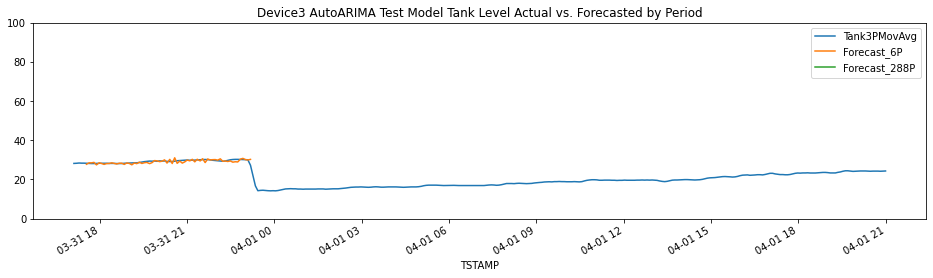

In [58]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values
df_dict = {3:forecasts_df}
ids = [3]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(df_dict, ids, threshhold_col, actual_cols, forecast_cols, 
                         'AutoARIMA Test', flt_thrsh)

#### ARIMA Model Pipeline

In [59]:
%%time

# loop through ARIMA models for each device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# dict of model names and parameters (window size)
arima_models = {'AutoARIMA':[0]
         }

# initialize dict of model results
device_arima_model_rmse = {}
device_arima_model_order = {}

# initialize dict of forecast results
device_arima_model_forecasts = {}

# initialize dict of model processing times
device_arima_model_process_time = {}

for ii in device_ids:
    print(f'Processing device{ii}...')
    df = sap_devices[ii]

    for mm in arima_models:
        print(f'testing model {mm}')
        # store starting time 
        begin = time.time() 
        
        params = arima_models[mm]
        order, results, forecasts_df = model_arima_step_forward_validation(df, input_cols, target_cols, pct_test=0.25, 
                                                                           window_size=params[0], flt_thrsh=flt_thrsh,
                                                                           fcstP=periods)
        # store ending time
        end = time.time()
        print(f'auto arima model order: {order}')
        # capture device model order
        device_arima_model_order[f'device{ii}'] = [order]

        # capture model forecast results
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_arima_model_forecasts:
            device_arima_model_forecasts[mm][ii] = forecasts_df
        else:
            device_arima_model_forecasts[mm] = {}
            device_arima_model_forecasts[mm][ii] = forecasts_df        

        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_arima_model_process_time:
            device_arima_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_arima_model_process_time[devicekey] = {}
            device_arima_model_process_time[devicekey][mm] = (end - begin)            
        
        #populate rsme score for each period
        for pp in range(len(periods)):
            device_arima_model_rmse = set_device_model_rmse_dict(device_arima_model_rmse, f'device{ii}', 
                                                           mm+'_'+period_names[pp], results[pp][1])


Processing device1...
testing model AutoARIMA
processed obs 0 in the testing dataset
model size is now 4771 observations
predictions size is now 1 observations
processed obs 100 in the testing dataset
model size is now 4871 observations
predictions size is now 101 observations
processed obs 200 in the testing dataset
model size is now 4971 observations
predictions size is now 201 observations
processed obs 300 in the testing dataset
model size is now 5071 observations
predictions size is now 301 observations
processed obs 400 in the testing dataset
model size is now 5171 observations
predictions size is now 401 observations
processed obs 500 in the testing dataset
model size is now 5271 observations
predictions size is now 501 observations
processed obs 600 in the testing dataset
model size is now 5371 observations
predictions size is now 601 observations
processed obs 700 in the testing dataset
model size is now 5471 observations
predictions size is now 701 observations
processed obs 

processed obs 500 in the testing dataset
model size is now 6926 observations
predictions size is now 501 observations
processed obs 600 in the testing dataset
model size is now 7026 observations
predictions size is now 601 observations
processed obs 700 in the testing dataset
model size is now 7126 observations
predictions size is now 701 observations
processed obs 800 in the testing dataset
model size is now 7226 observations
predictions size is now 801 observations
processed obs 900 in the testing dataset
model size is now 7326 observations
predictions size is now 901 observations
processed obs 1000 in the testing dataset
model size is now 7426 observations
predictions size is now 1001 observations
processed obs 1100 in the testing dataset
model size is now 7526 observations
predictions size is now 1101 observations
processed obs 1200 in the testing dataset
model size is now 7626 observations
predictions size is now 1201 observations
processed obs 1300 in the testing dataset
model si

auto arima model order: (6, 0, 0)
Processing device10...
testing model AutoARIMA
processed obs 0 in the testing dataset
model size is now 2636 observations
predictions size is now 1 observations
processed obs 100 in the testing dataset
model size is now 2736 observations
predictions size is now 101 observations
processed obs 200 in the testing dataset
model size is now 2836 observations
predictions size is now 201 observations
processed obs 300 in the testing dataset
model size is now 2936 observations
predictions size is now 301 observations
processed obs 400 in the testing dataset
model size is now 3036 observations
predictions size is now 401 observations
processed obs 500 in the testing dataset
model size is now 3136 observations
predictions size is now 501 observations
processed obs 600 in the testing dataset
model size is now 3236 observations
predictions size is now 601 observations
processed obs 700 in the testing dataset
model size is now 3336 observations
predictions size is 

In [60]:
# convert model results dict to a dataframe
device_arima_model_rmse_df = pd.DataFrame.from_dict(device_arima_model_rmse, orient='index')
device_arima_model_order_df = pd.DataFrame.from_dict(device_arima_model_order, orient='index', columns = ['model_order'])

# convert model processing times dict to a dataframe
device_arima_model_process_time_df = pd.DataFrame.from_dict(device_arima_model_process_time, orient='index')

# save results to file
device_arima_model_rmse_df.to_csv('data/AutoARIMA_model_results_alldevices.csv', index=True, header=True)
device_arima_model_order_df.to_csv('data/AutoARIMA_model_orders_alldevices.csv', index=True, header=True)
device_arima_model_process_time_df.to_csv('data/AutoARIMA_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_arima_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('ARIMA forecast RMSE results:')
device_arima_model_rmse_df  
            

ARIMA forecast RMSE results:


,AutoARIMA_1P,AutoARIMA_6P,AutoARIMA_12P,AutoARIMA_36P,AutoARIMA_72P,AutoARIMA_144P,AutoARIMA_288P
device1,1.564449,7.095332,9.026411,15.998846,18.072648,18.460295,17.531743
device3,0.497515,1.594889,2.055874,4.474630,6.822788,8.398565,8.696344
device4,1.710624,6.303935,7.247062,11.151720,12.481782,16.051383,19.682539
device5,1.699809,4.811432,5.426072,6.927412,8.989095,9.832821,7.233139
device6,0.292915,2.379371,3.017414,6.310860,9.777925,13.040862,14.546549
device7,1.280591,5.597476,9.847924,19.834136,25.620726,27.017746,25.647575
device9,1.016255,4.472980,7.565262,18.914976,29.166882,36.826873,42.885600
device10,3.594285,12.661526,18.191503,27.052439,25.419593,25.384438,24.888963
device11,0.777450,3.269615,5.351487,9.527568,12.878945,17.158590,30.338021


In [61]:
print('ARIMA model orders:')
device_arima_model_order_df

ARIMA model orders:


,model_order
device1,"(5, 0, 1)"
device3,"(5, 0, 2)"
device4,"(6, 0, 5)"
device5,"(6, 0, 1)"
device6,"(2, 0, 1)"
device7,"(5, 0, 2)"
device9,"(6, 0, 0)"
device10,"(5, 0, 2)"
device11,"(5, 0, 2)"


#### ARIMA Model Results

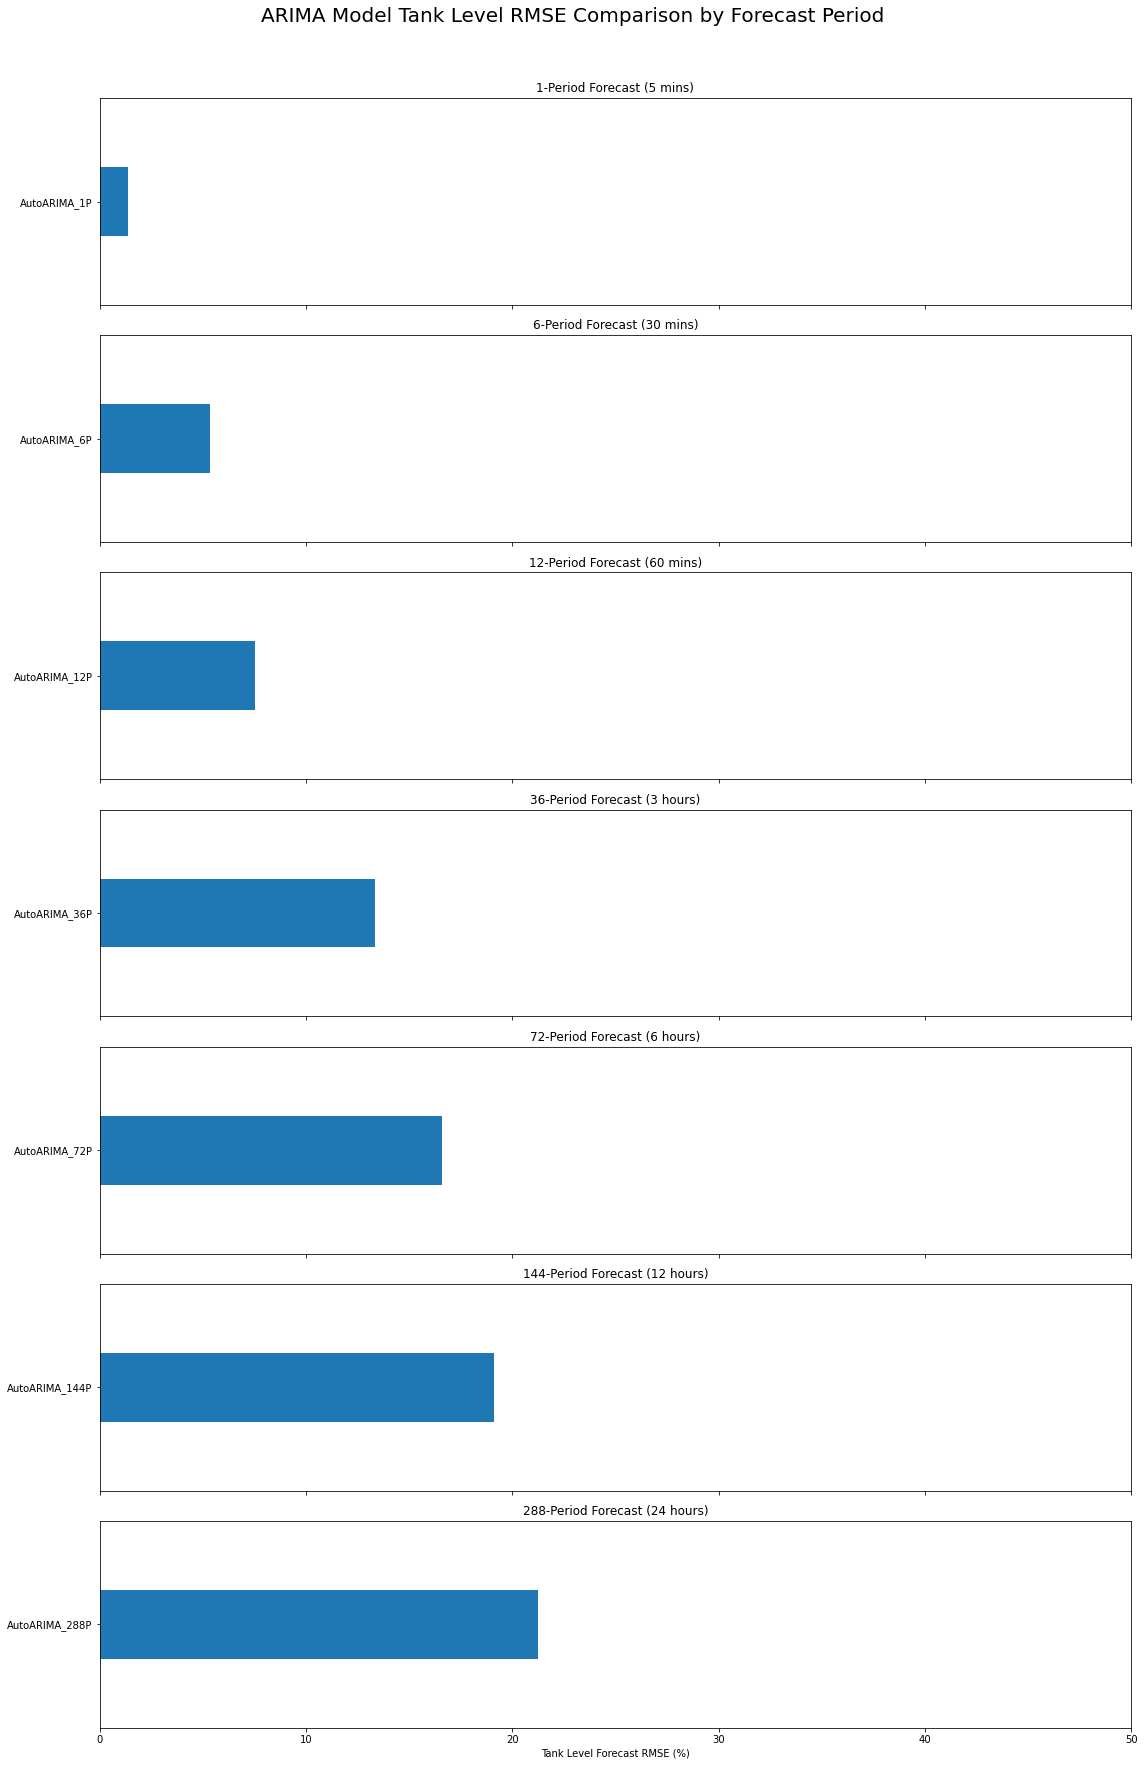

In [62]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
arima_model_cols = get_model_result_cols_by_period(period_names, arima_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(arima_model_cols, device_arima_model_rmse_df, 
                                 'ARIMA Model Tank Level RMSE Comparison by Forecast Period')


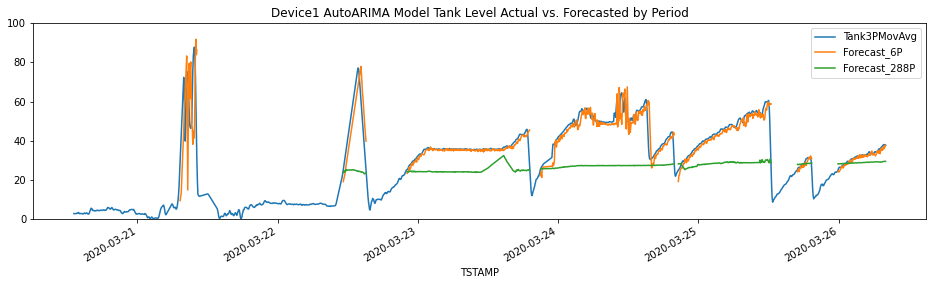

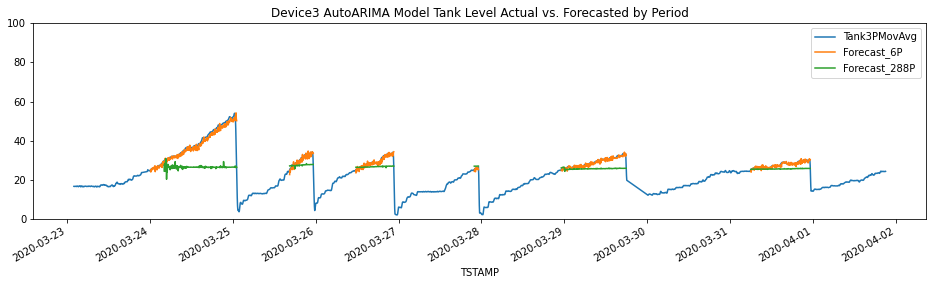

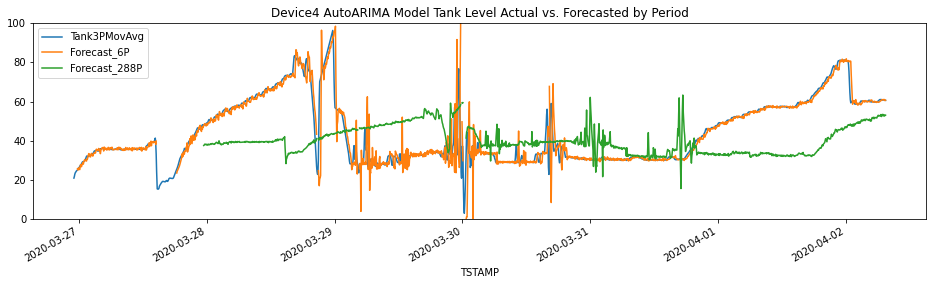

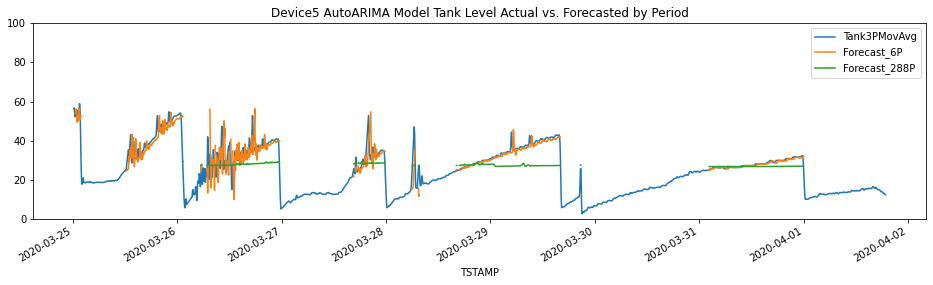

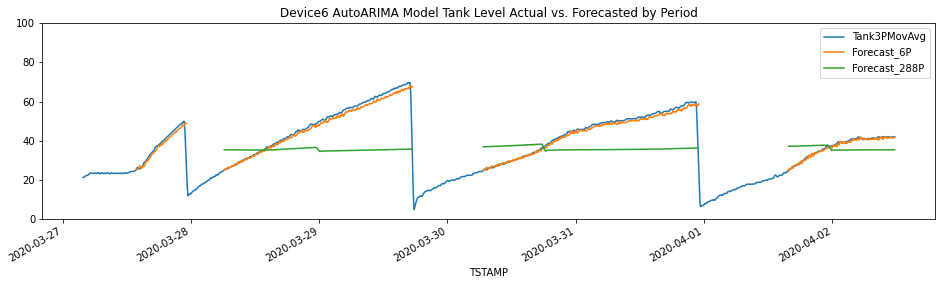

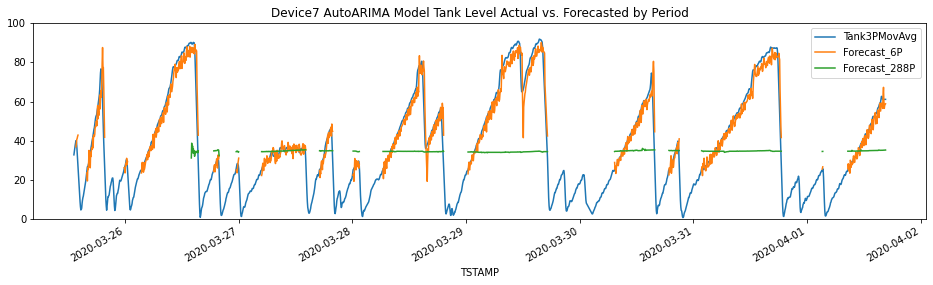

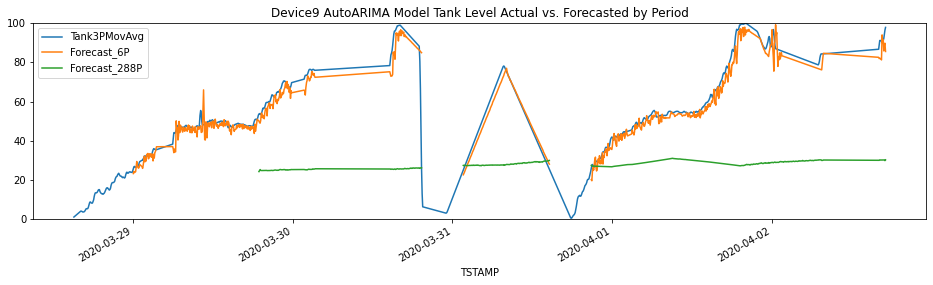

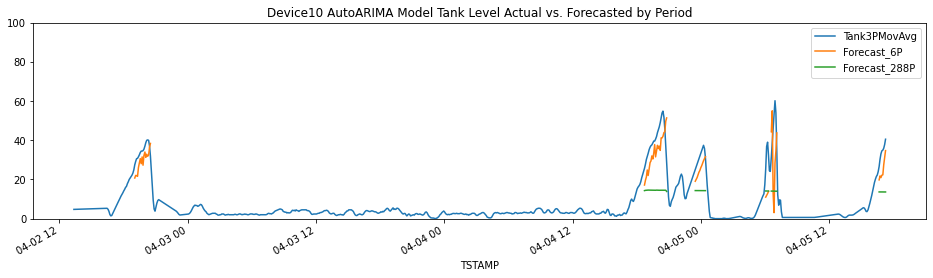

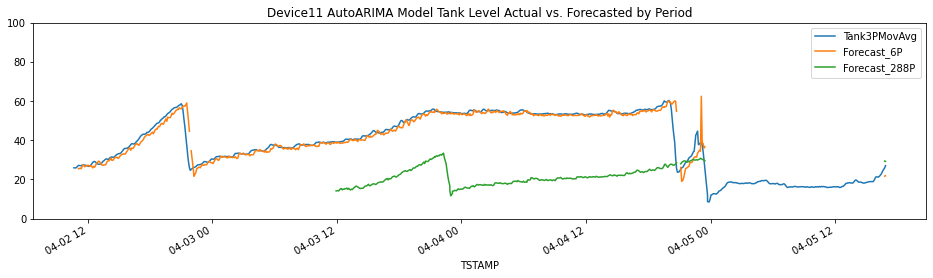

In [63]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
arima_forecasts = forecastcsv_to_dfs(file='data/AutoARIMA_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(arima_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 
                         'AutoARIMA', flt_thrsh)


### ARIMA Exog walk-forward testing

In [64]:
# auto fit best arima model with exog features
def auto_arimaexog_model(train_data, train_exogs):

    model = pm.auto_arima(train_data, exogenous=train_exogs, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=6, max_q=6, # maximum p and q
                          m=1,              # frequency of series 1 == no seasonality
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

    # return (p,d,q) params of selected model
    return model, model.order

# return arima exog model forecasts
def model_arimaexog_forecast(model, exogs, fcstP):
    # get period-ahead prediction (predict_in_sample is pmdarima method)
    predicts = []
    for pp in range(len(fcstP)):
        if len(exogs) >= (model.nobs_ +fcstP[pp] + 1): 
            # add random noise to each 'future' temp value
            exg = exogs.iloc[(model.nobs_):(model.nobs_ + fcstP[pp]) + 1].applymap(lambda x: x + np.random.normal(0,1))
            predict = model.predict_in_sample(exogenous=exg, start=model.nobs_+fcstP[pp], end=model.nobs_+fcstP[pp])
            # convert to scalar
            predict = predict.item()
            if predict > 100: predict = 100
            if predict < 0: predict = 0
        else:
            predict = np.nan

        predicts.append(predict)
    # return prediction
    return predicts

# function to process arima exog model step-forward validation
def model_arimaexog_step_forward_validation(df, input_cols, target_cols, pct_test=0.2, window_size=0,
                                     fcstP=[1], flt_thrsh=0, printout=False):
    
    # input values of time series
    inputs = np.array(df[input_cols[0]])

    #split train and test data
    n_test = int(len(inputs)*pct_test)
    train = inputs[:-n_test]
    test = inputs[-n_test:]

    #initialize dataframe to store actuals and predictions
    #  the initial df is populated with the device id, predicted input, and exog input
    #  add offset of the first forcast period to align with periodtargets
    forecasts_df = df[['DEVICE_ID',input_cols[0],'TempF']][-n_test+fcstP[0]:]

    # external predictor variables
    exogs_train = df[['TempF']][:-n_test] # training exogs
    exogs_test = df[['TempF']][-n_test:] # testing exogs
    exogs = df[['TempF']] # full set of exogs for full model step-forward forecasting
    
    # timestamp index of target values
    testtargetidx = df[input_cols[0]][-n_test:].index.to_series()
    # reset index from datetime to int
    testtargetidx = testtargetidx.reset_index(drop=True)

    # period target values
    periodtargets = []
    periodtargetsidx = []
    for cc in range(len(target_cols)):
        # build list of period targets
        # filter rows with NaN in the target column
        filtnan = ~df[target_cols[cc]][-n_test:].isna()
        # convert to numpy arrays
        targets = np.array(df[target_cols[cc]][-n_test:][filtnan])
        periodtargets.append([targets])

        # build list of period target timestamps
        # filter rows with NaN in the target column
        filtnanidx = ~df[target_cols[cc]][-n_test:].isna().reset_index(drop=True)
        # align timestamp index of target value by shifting target timestamps backward
        idx = testtargetidx.shift(-fcstP[cc])
        assert len(filtnanidx) == len(idx)
        idx = idx[filtnanidx]
        periodtargetsidx.append([idx])    
        

    #initialize predictions list
    predictions = []

    # get estimated model order to use for model building
    model, order = auto_arimaexog_model(train, exogs_train)
    # step into each time-step in the test set
    for ii in range(len(test)):
        # update model with new test observation
        if ii < len(test)-1: exg = exogs_test.iloc[ii:ii+1]
        if ii == len(test)-1: exg = exogs_test.iloc[-1:]

        model.update(test[ii], exogenous=exg)

        # get forecast values
        predicts = model_arimaexog_forecast(model, exogs, fcstP=fcstP)        

        # store forecasts in lists of predictions
        for cc in range(len(target_cols)):
            if len(predictions) < len(target_cols):
                predictions.append([predicts[cc]])
            else:
                predictions[cc].append(predicts[cc])

        # print status message for every 100 observations processed
        if ii % 100 == 0: print(f'exog processed obs {ii} in the testing dataset')        
        if ii % 100 == 0: print(f'exog model size is now {model.nobs_} observations')                    
        if ii % 100 == 0: print(f'exog predictions size is now {len(predictions[0])} observations')

    # loop through each period predictions to measure results of actual vs. forecast
    results = [] # list of results metrics
    dfs = [forecasts_df] # list of dataframes of forecasts for plotting
    for cc in range(len(target_cols)):
        # create array of target actuals for each period
        testactuals = np.asarray(periodtargets[cc][0])
        # create array of forecasts as the same length as the test actuals
        forecasts = np.asarray(predictions[cc][:len(testactuals)])
        assert len(testactuals) == len(forecasts)
        
        # filter forecasts and actuals indexes with NaN in the forecasts        
        filtnan = ~np.isnan(forecasts)
        testactuals = testactuals[filtnan]
        forecasts = forecasts[filtnan]

        # build df of forecasts aligned index of actual time
        df = pd.DataFrame(data=forecasts, index=periodtargetsidx[cc][0][-len(forecasts):], columns=[f'Forecast_{fcstP[cc]}P'])
        dfs.append(df)
        
        # get results per period
        mse, rmse, r2score = rmse_results(testactuals, forecasts, flt_thrsh=flt_thrsh, printout=printout)
        # append results to results list
        results.append([mse, rmse, r2score])

    forecasts_df = pd.concat(dfs, axis=1)          
        
    return order, results, forecasts_df

#### Single Device Test

In [65]:
%%time

# loop through ARIMA models for a single device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]

# use filter threshold of 0 for testing
order, results, forecasts_df = model_arimaexog_step_forward_validation(sap_devices[3], input_cols, target_cols, pct_test=0.03, 
                                                      window_size=0, fcstP=periods, flt_thrsh=0, printout=True)

print(order)
print(results)


exog processed obs 0 in the testing dataset
exog model size is now 10513 observations
exog predictions size is now 1 observations
exog processed obs 100 in the testing dataset
exog model size is now 10613 observations
exog predictions size is now 101 observations
exog processed obs 200 in the testing dataset
exog model size is now 10713 observations
exog predictions size is now 201 observations
exog processed obs 300 in the testing dataset
exog model size is now 10813 observations
exog predictions size is now 301 observations
Mean squared error on test data: 0.3416
Root mean squared error on test data: 0.5845
R-Squared score on test data: 0.9861
Mean squared error on test data: 4.3238
Root mean squared error on test data: 2.0794
R-Squared score on test data: 0.8209
Mean squared error on test data: 8.8934
Root mean squared error on test data: 2.9822
R-Squared score on test data: 0.6235
Mean squared error on test data: 25.1335
Root mean squared error on test data: 5.0133
R-Squared score 

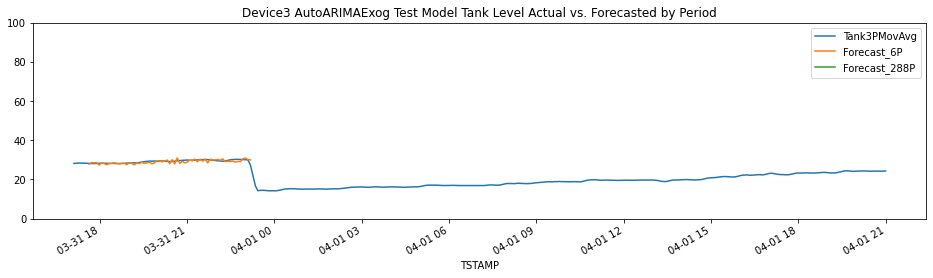

In [66]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values
df_dict = {3:forecasts_df}
ids = [3]

actual_cols = ['Tank3PMovAvg']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(df_dict, ids, threshhold_col, actual_cols, forecast_cols, 
                         'AutoARIMAExog Test', flt_thrsh)



#### ARIMA Exog Model Pipeline

In [67]:
%%time

# loop through ARIMA models for each device

input_cols = ['Tank3PMovAvg']
target_cols = ['Tank3PMATgt1P','Tank3PMATgt6P','Tank3PMATgt12P', 'Tank3PMATgt36P',
              'Tank3PMATgt72P','Tank3PMATgt144P','Tank3PMATgt288P']
period_names = ['1P','6P','12P', '36P', '72P', '144P', '288P']
periods = [1, 6, 12, 36, 72, 144, 288]
# dict of model names and parameters (window size)
arimaexog_models = {'AutoARIMAExog':[0]
         }

# initialize dict of model results
device_arimaexog_model_rmse = {}
device_arimaexog_model_order = {}

# initialize dict of forecast results
device_arimaexog_model_forecasts = {}

# initialize dict of model processing times
device_arimaexog_model_process_time = {}

for ii in device_ids:
    print(f'Processing device{ii}...')
    df = sap_devices[ii]

    for mm in arimaexog_models:
        print(f'testing model {mm}')
        # store starting time 
        begin = time.time()
        
        params = arimaexog_models[mm]
        order, results, forecasts_df = model_arimaexog_step_forward_validation(df, input_cols, target_cols, pct_test=0.25, 
                                                                               window_size=params[0], flt_thrsh=flt_thrsh,
                                                                               fcstP=periods)
        # store ending time
        end = time.time()
        
        print(f'auto arima exog model order: {order}')
        # capture device model order
        device_arimaexog_model_order[f'device{ii}'] = [order]
        
        # capture model forecast results
        # nested forecast dict {ModelName: {deviceX:df, deviceY:df, deviceZ:df}}
        if mm in device_arimaexog_model_forecasts:
            device_arimaexog_model_forecasts[mm][ii] = forecasts_df
        else:
            device_arimaexog_model_forecasts[mm] = {}
            device_arimaexog_model_forecasts[mm][ii] = forecasts_df  
            
        # capture model processing time results
        devicekey = f'device{ii}'
        if devicekey in device_arimaexog_model_process_time:
            device_arimaexog_model_process_time[devicekey][mm] = (end - begin)
        else:
            device_arimaexog_model_process_time[devicekey] = {}
            device_arimaexog_model_process_time[devicekey][mm] = (end - begin)            

        
        #populate rsme score for each period
        for pp in range(len(periods)):
            device_arimaexog_model_rmse = set_device_model_rmse_dict(device_arimaexog_model_rmse, f'device{ii}', 
                                                           mm+'_'+period_names[pp], results[pp][1])


Processing device1...
testing model AutoARIMAExog
exog processed obs 0 in the testing dataset
exog model size is now 4771 observations
exog predictions size is now 1 observations
exog processed obs 100 in the testing dataset
exog model size is now 4871 observations
exog predictions size is now 101 observations
exog processed obs 200 in the testing dataset
exog model size is now 4971 observations
exog predictions size is now 201 observations
exog processed obs 300 in the testing dataset
exog model size is now 5071 observations
exog predictions size is now 301 observations
exog processed obs 400 in the testing dataset
exog model size is now 5171 observations
exog predictions size is now 401 observations
exog processed obs 500 in the testing dataset
exog model size is now 5271 observations
exog predictions size is now 501 observations
exog processed obs 600 in the testing dataset
exog model size is now 5371 observations
exog predictions size is now 601 observations
exog processed obs 700 

exog processed obs 1600 in the testing dataset
exog model size is now 6965 observations
exog predictions size is now 1601 observations
exog processed obs 1700 in the testing dataset
exog model size is now 7065 observations
exog predictions size is now 1701 observations
auto arima exog model order: (6, 0, 3)
Processing device5...
testing model AutoARIMAExog
exog processed obs 0 in the testing dataset
exog model size is now 6426 observations
exog predictions size is now 1 observations
exog processed obs 100 in the testing dataset
exog model size is now 6526 observations
exog predictions size is now 101 observations
exog processed obs 200 in the testing dataset
exog model size is now 6626 observations
exog predictions size is now 201 observations
exog processed obs 300 in the testing dataset
exog model size is now 6726 observations
exog predictions size is now 301 observations
exog processed obs 400 in the testing dataset
exog model size is now 6826 observations
exog predictions size is n

exog processed obs 1800 in the testing dataset
exog model size is now 7759 observations
exog predictions size is now 1801 observations
exog processed obs 1900 in the testing dataset
exog model size is now 7859 observations
exog predictions size is now 1901 observations
auto arima exog model order: (6, 0, 1)
Processing device9...
testing model AutoARIMAExog
exog processed obs 0 in the testing dataset
exog model size is now 3376 observations
exog predictions size is now 1 observations
exog processed obs 100 in the testing dataset
exog model size is now 3476 observations
exog predictions size is now 101 observations
exog processed obs 200 in the testing dataset
exog model size is now 3576 observations
exog predictions size is now 201 observations
exog processed obs 300 in the testing dataset
exog model size is now 3676 observations
exog predictions size is now 301 observations
exog processed obs 400 in the testing dataset
exog model size is now 3776 observations
exog predictions size is n

In [68]:
# convert model results dict to a dataframe
device_arimaexog_model_rmse_df = pd.DataFrame.from_dict(device_arimaexog_model_rmse, orient='index')
device_arimaexog_model_order_df = pd.DataFrame.from_dict(device_arimaexog_model_order, orient='index', columns = ['model_order'])

# convert model processing times dict to a dataframe
device_arimaexog_model_process_time_df = pd.DataFrame.from_dict(device_arimaexog_model_process_time, orient='index')

# save results to file
device_arimaexog_model_rmse_df.to_csv('data/AutoARIMAExog_model_results_alldevices.csv', index=True, header=True)
device_arimaexog_model_order_df.to_csv('data/AutoARIMAExog_model_orders_alldevices.csv', index=True, header=True)
device_arimaexog_model_process_time_df.to_csv('data/AutoARIMAExog_model_process_time_alldevices.csv', index=True, header=True)

# save forecasts to file
forecastdfs_to_csv(dfs=device_arimaexog_model_forecasts, filesuffix='_model_forecasts_alldevices.csv')

print('ARIMA forecast results:')
device_arimaexog_model_rmse_df  


ARIMA forecast results:


,AutoARIMAExog_1P,AutoARIMAExog_6P,AutoARIMAExog_12P,AutoARIMAExog_36P,AutoARIMAExog_72P,AutoARIMAExog_144P,AutoARIMAExog_288P
device1,1.545244,7.058311,9.195110,16.146078,18.381405,18.743488,17.343903
device3,0.460835,1.590688,1.963898,4.030034,6.326334,8.326135,8.742336
device4,1.694251,6.219752,7.105581,10.823666,12.448759,15.994360,17.976184
device5,1.700527,4.807507,5.410201,6.848342,8.822840,9.601038,7.069781
device6,0.328647,2.381740,3.007938,6.254652,9.652927,12.852199,14.359426
device7,1.261191,5.727205,10.017153,19.709595,25.527543,27.041723,25.594763
device9,1.026756,4.471481,7.527317,18.543525,28.668894,36.317249,42.499935
device10,3.599458,12.676055,18.016084,27.118341,25.451049,25.327676,24.859923
device11,0.776739,3.267986,5.357183,9.564668,13.013165,17.530555,30.925556


In [69]:
print('ARIMA model orders:')
device_arimaexog_model_order_df

ARIMA model orders:


,model_order
device1,"(6, 0, 1)"
device3,"(6, 0, 1)"
device4,"(6, 0, 3)"
device5,"(6, 0, 1)"
device6,"(2, 0, 1)"
device7,"(6, 0, 1)"
device9,"(6, 0, 1)"
device10,"(4, 0, 2)"
device11,"(5, 0, 2)"


#### ARIMA Exog Model Results

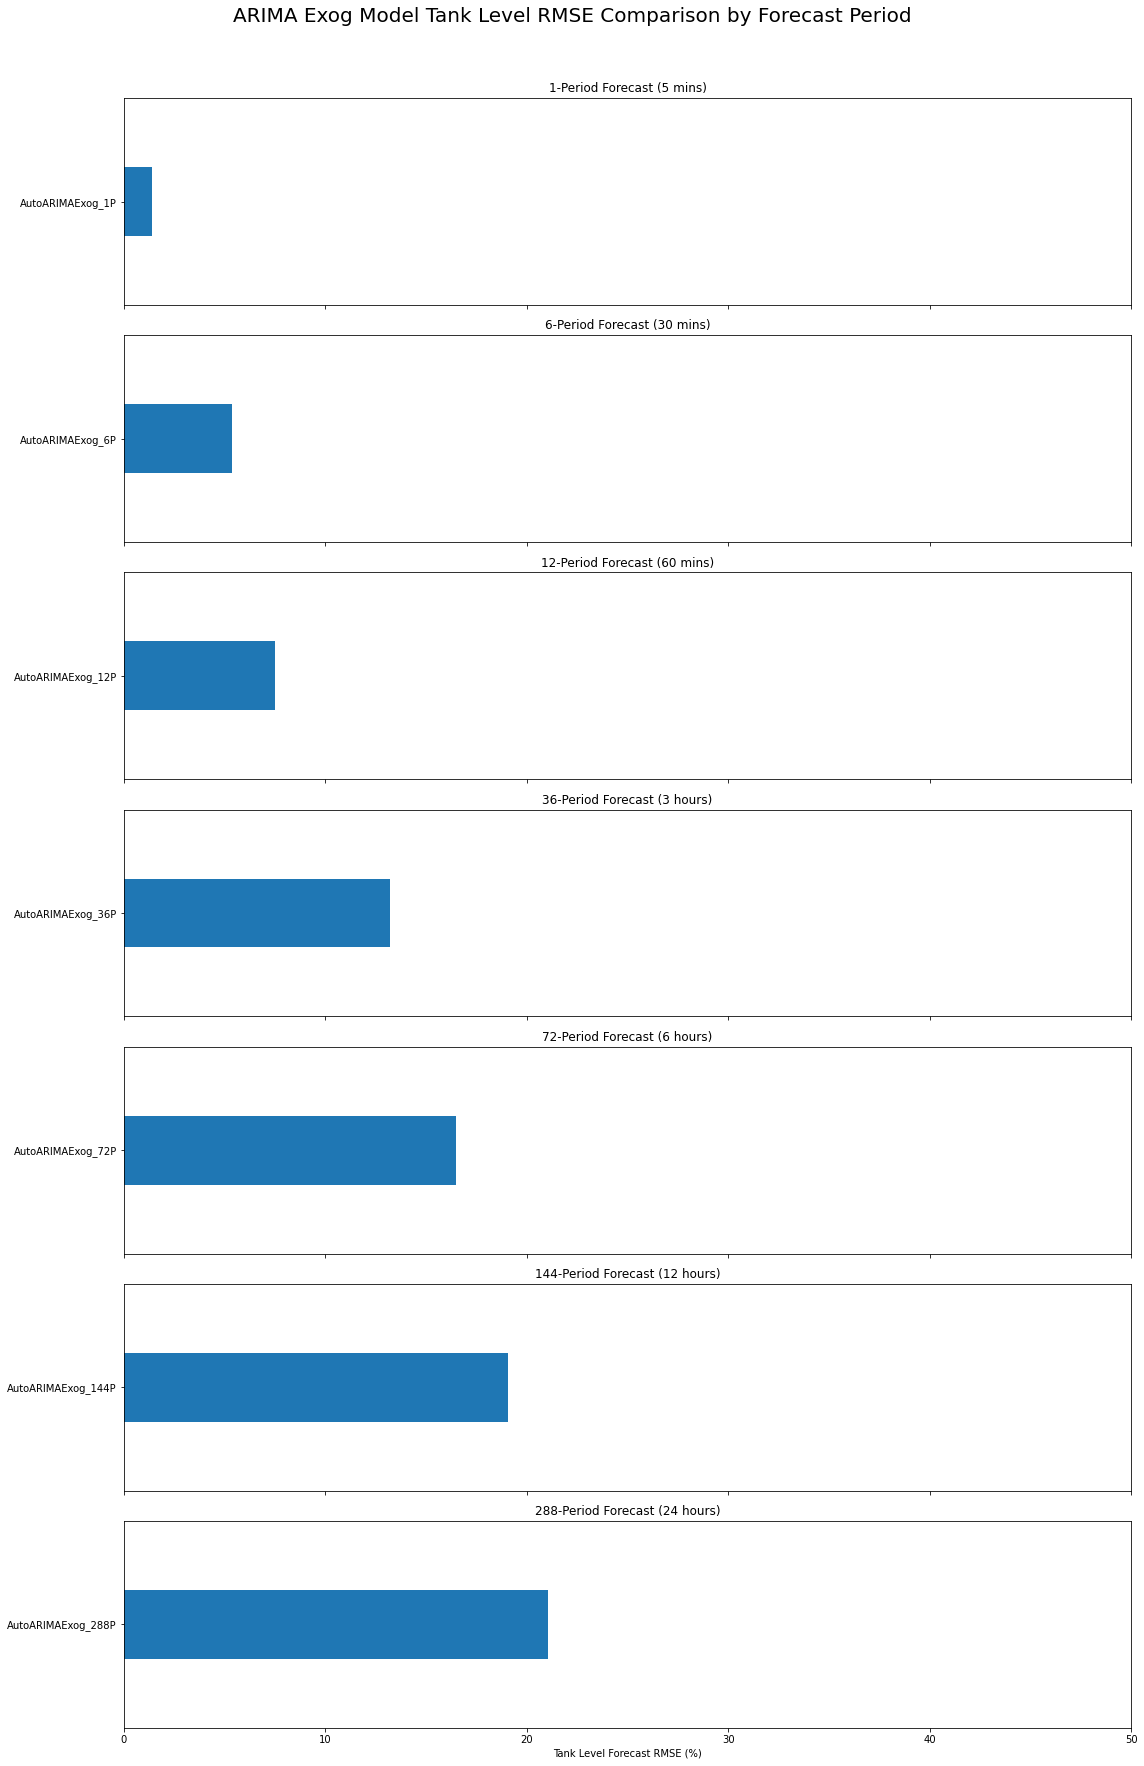

In [70]:
# plot model results
%matplotlib inline

# get model RMSE result period columns list
arimaexog_model_cols = get_model_result_cols_by_period(period_names, arimaexog_models)

# plot model RMSE results by forecast period
plot_model_rmse_results_by_period(arimaexog_model_cols, device_arimaexog_model_rmse_df, 
                                 'ARIMA Exog Model Tank Level RMSE Comparison by Forecast Period')


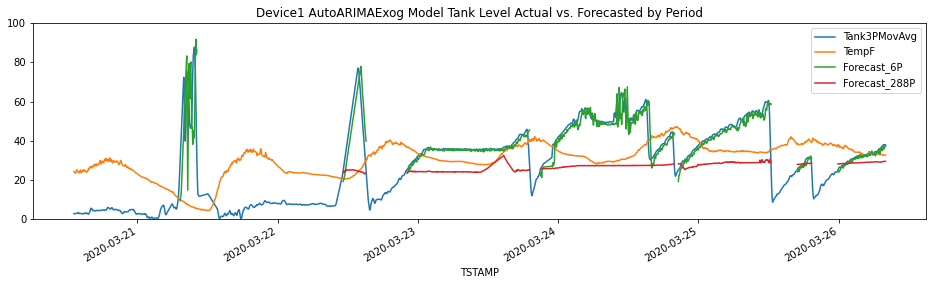

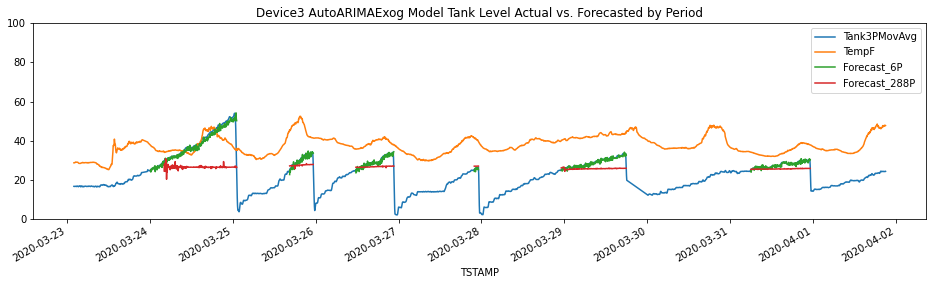

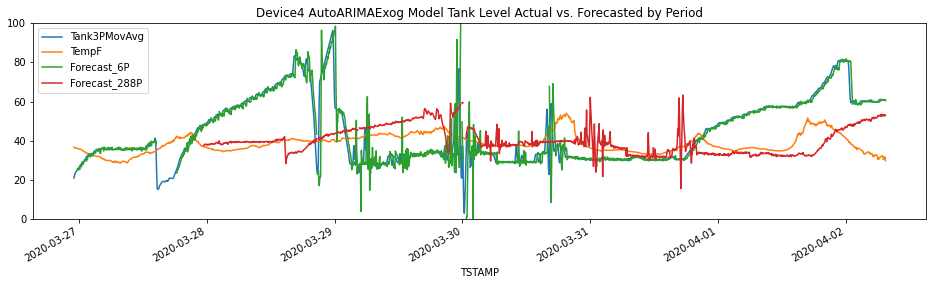

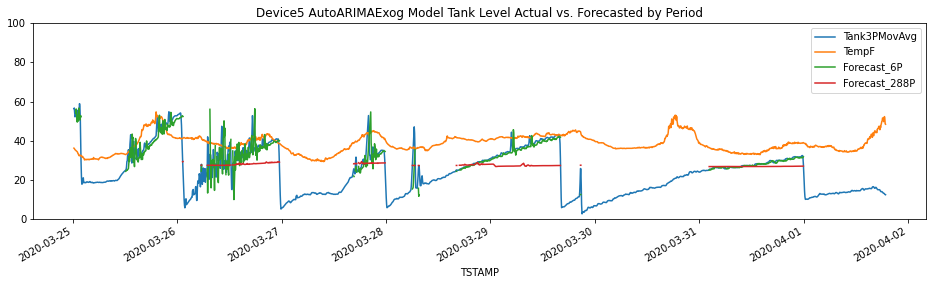

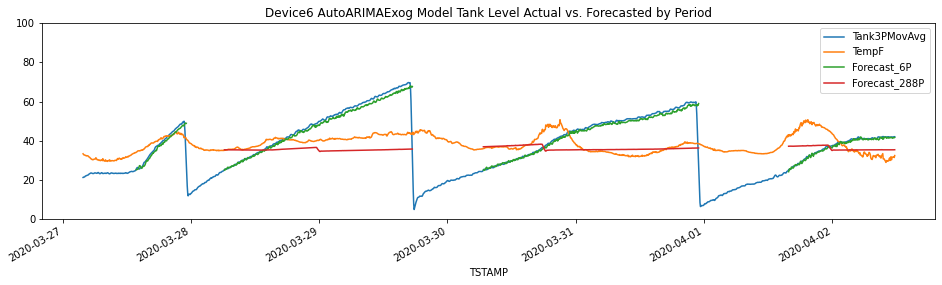

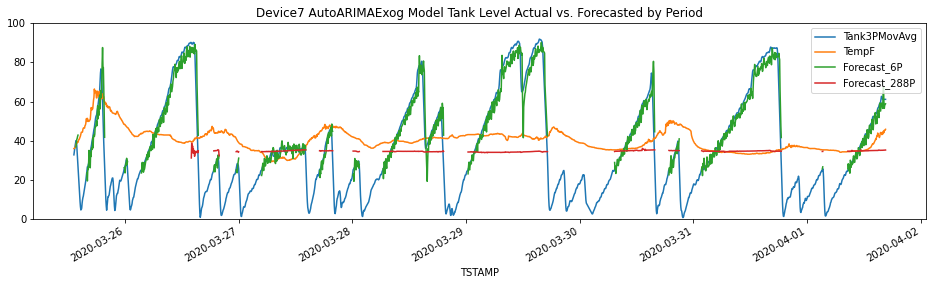

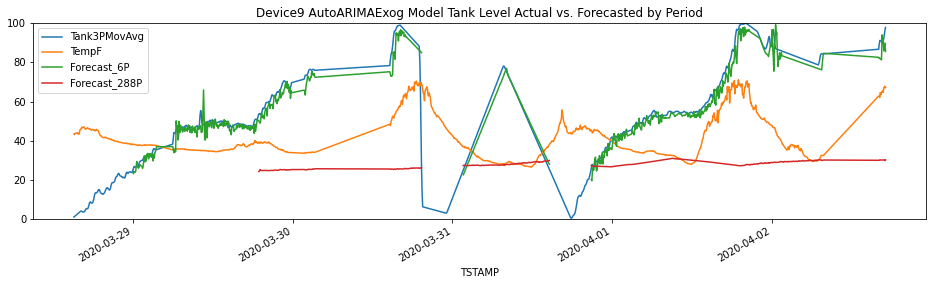

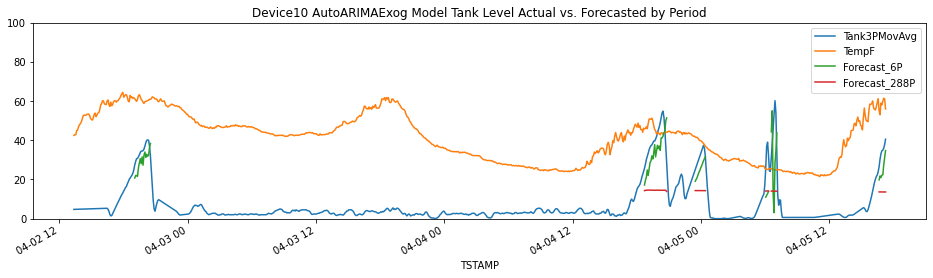

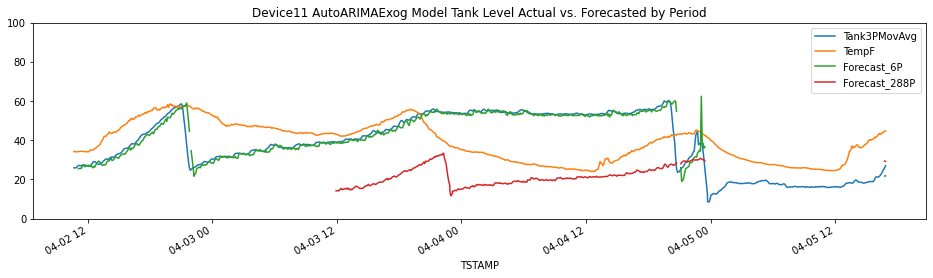

In [71]:
# plot model results
%matplotlib inline

# plot comparison of tank level actual vs. forecast values

# get dfs from forecast file
arimaexog_forecasts = forecastcsv_to_dfs(file='data/AutoARIMAExog_model_forecasts_alldevices.csv', device_ids=device_ids)

actual_cols = ['Tank3PMovAvg', 'TempF']
forecast_cols = ['Forecast_6P', 'Forecast_288P']
threshhold_col = 'Tank3PMovAvg'

plot_forecasts_by_device(arima_forecasts, device_ids, threshhold_col, actual_cols, forecast_cols, 
                         'AutoARIMAExog', flt_thrsh)
